# Построение модели на основе данных рейтинга отелей Booking.com
---
---

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Booking.com_Logo.svg/500px-Booking.com_Logo.svg.png)

# Какой кейс решаем?
---

Представьте, что вы работаете дата-сайентистом в компании *Booking*. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

**Метрика качества:**  
Результаты оцениваются по метрике *MAPE*. Файл представления для каждого **id** отеля в наборе тестовых данных должен предсказать рейтинг отеля для **reviewer_score** переменной. Файл должен содержать заголовок и иметь следующий формат: ``` reviewer_score,id 1,1 ```

In [62]:
# Импортируем необходимые библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import category_encoders as ce
from sklearn import preprocessing
from scipy import stats
from termcolor import colored
from geopy.distance import geodesic
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [63]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы.
RANDOM_SEED = 42

In [64]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы.
!pip freeze > requirements.txt

# 1. Предварительная работа с данными
---

**Файлы для соревнования:**

- `hotels_train.csv` - набор данных для обучения;

- `hotels_test.csv` - набор данных для оценки качества;

- `submission.csv` - файл сабмишна в нужном формате.

## 1.1 Подгружаем данные

In [65]:
# Подгрузим наши данные из соревнования
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

## 1.2 Описательный анализ исходных данных.

In [66]:
# Основные характеристики датасета для обучения.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [67]:
# Основные характеристики датасета для предсказания.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [68]:
# Основные характеристики сабмишена и его вид.
sample_submission.info()
print()
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB



,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [69]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем где у нас трейн.
df_test['sample'] = 0 # помечаем где у нас тест.
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями.

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) # объединяем.
# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем.

In [70]:
#Выводим общую информацию.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [71]:
# Отображаем структуру датасета.
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


Версия датасета для проведения дальнейшего разведывательного анализа (*EDA*) содержит 17 основных признаков и 1 вспомогательный - столбцов и 515 738 отзывов - строк, из которых 386 803 строк тренировочного датасета, 128 935 – тестового датасета (75 % и 25 % соответственно):

|Название признака|Значение признака|
|-----------------|-----------------|
|`hotel_address`|адрес отеля|
|`review_date`|дата, когда рецензент разместил соответствующий отзыв|
|`average_score`|средний балл отеля, рассчитанный на основе последнего комментария за последний год|
|`hotel_name`|название отеля|
|`reviewer_nationality`|страна рецензента|
|`negative_review`|отрицательный отзыв, который рецензент дал отелю|
|`review_total_negative_word_counts`|общее количество слов в отрицательном отзыве|
|`positive_review`|положительный отзыв, который рецензент дал отелю|
|`review_total_positive_word_counts`|общее количество слов в положительном отзыве|
|`reviewer_score`*|оценка, которую рецензент поставил отелю на основе своего опыта (целевой признак)|
|`total_number_of_reviews_reviewer_has_given`|количество отзывов, которые рецензенты дали в прошлом|
|`total_number_of_reviews`|общее количество действительных отзывов об отеле|
|`tags`|теги, которые рецензент дал отелю|
|`days_since_review`|количество дней между датой проверки и датой очистки|
|`additional_number_of_scoring`|есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.|
|`lat`|географическая широта отеля|
|`lng`|географическая долгота отеля|
|`sample`*|вспомогательный признак разделения строк датасета на тренировочную и тестовую части (1 и 0 соответственно)|

## 1.3 Очистка данных

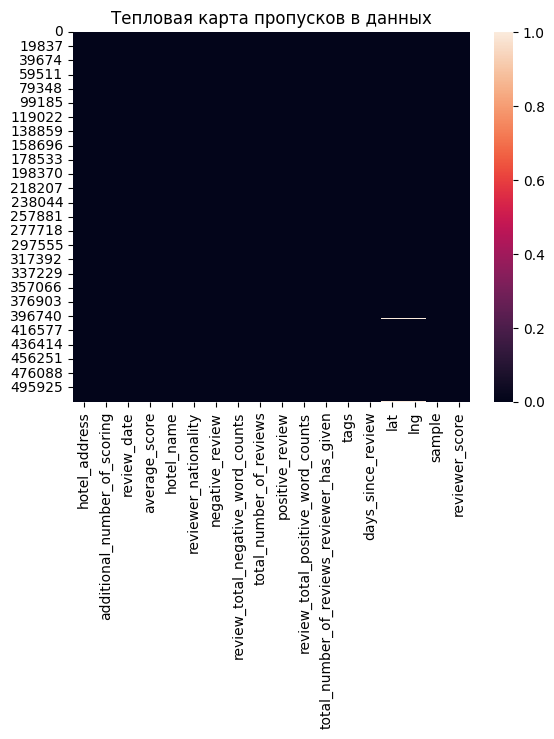

In [72]:
# Осуществляем визуализацию признаков, имеющих пропуски.
plot = sns.heatmap(data.isnull())
plot.set_title('Тепловая карта пропусков в данных', fontsize=12);

In [73]:
# Процент пропусков и их количество в признаках датасета.
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(colored(f'\nПроцентное соотношение пропусков:', 'green'))
display(cols_with_null)

cols_null_count = data.isnull().sum()[data.isnull().sum()>0].sort_values(ascending=False)
print(colored(f'\nКоличество пропусков:', 'green'))
display(cols_null_count)


Процентное соотношение пропусков:


lat    0.633655
lng    0.633655
dtype: float64


Количество пропусков:


lat    3268
lng    3268
dtype: int64

In [74]:
# Создаем функцию для проверки нахождения пропусков в признаках в рамках одной строки.
def latlng_row_check(lng):
    """
    Функция для проверки пропусков `lat` и 'lng' в рамках одной строки.
    Args:
        lng (float): долгота из признака `lng`

    Returns:
        None: изменяет счетчик `true_counter_lng`
    """
    global true_counter_lng
    if lng:
        true_counter_lng+=1

        
# Создаем счетчик смежных пропусков в данных.
true_counter_lng = 0
data.isnull()[data.isnull()['lat']==True]['lng'].apply(latlng_row_check)

print(colored(f'Количество двойных пропусков в рамках одной строки:', 'green'))
print(true_counter_lng)

Количество двойных пропусков в рамках одной строки:
3268


**Предварительный вывод по анализу пропусков:**

Только в двух признаках `lat` и `lng` (широта и долгота соответственно) в рамках одной строки имеются пропуски в 3 268 строках, что составляет менее 1 % от всего датасета. На первый взгляд было бы целесообразным заменить пропуски модальным значением, однако для достижения в конечном итоге более точных метрик модели целесообразно заполнить их используя данные из признака `hotel_address`.

In [75]:
# Определяем количество отелей без координат и создаем список из их названий.
data_null = data[data.isnull().any(axis=1)]
no_cord_hotels = list(data_null['hotel_name'].unique())
count_no_cord_hotels = len(data_null['hotel_name'].unique())

print(f'Количество отелей без координат: {count_no_cord_hotels}.')

Количество отелей без координат: 17.


С учетом выявленных изначальных ошибок в датасете в признаке `hotel_address` в части пропусков ряда символов в названиях улиц, например таких как **ß** в австрийских и **ú** в испанских, принято решение провести ручной поиск координат расположения отелей с пропусками в признаках `lat` и `lng` с учетом малого их количества (17 отелей) для последующего заполнения пропусков посредством сервиса *[GoogleMaps](https://www.google.com/maps)*:

In [76]:
# Словарь с координатами отелей.
latlng_dict = {'Hotel Atlanta': (48.220304, 16.355798),
              'City Hotel Deutschmeister': (48.220828, 16.366628),
              'Holiday Inn Paris Montmartre': (48.888918, 2.333105),
              'Fleming s Selection Hotel Wien City': (48.209423, 16.353509),
              'Hotel City Central': (48.213575, 16.379895),
              'Cordial Theaterhotel Wien': (48.209544, 16.351442),
              'NH Collection Barcelona Podium': (41.391618, 2.177920),
              'Hotel Daniel Vienna': (48.188814, 16.383929),
              'Maison Albar Hotel Paris Op ra Diamond': (48.875303, 2.323306),
              'Mercure Paris Gare Montparnasse': (48.837957, 2.318591),
              'Hotel Pension Baron am Schottentor': (48.216792, 16.359937),
              'Austria Trend Hotel Schloss Wilhelminenberg Wien': (48.219576, 16.285592),
              'Renaissance Barcelona Hotel': (41.392701, 2.167428),
              'Derag Livinghotel Kaiser Franz Joseph Vienna': (48.246005, 16.341547),
              'Roomz Vienna': (48.186665, 16.420601),
              'Hotel Park Villa': (48.233600, 16.345713),
              'Hotel Advance': (41.383206, 2.162945)}

In [77]:
# Задаем функцию для заполнения значений широты в пропусках.
def lat_fill_func(name, lat):
    """
    Функция для заполнения широты `lat` с привязкой к названию отеля `hotel_name`.
    Args:
        name (str): название отеля из признака `hotel_name`

    Returns:
        float: значение широты для отеля.
    """
    global no_cord_hotels
    global latlng_dict
    if name in no_cord_hotels:
        return latlng_dict[name][0]
    else:
        return lat
        
    
# Задаем функцию для заполнения значений долготы в пропусках.
def lng_fill_func(name, lng):
    """
    Функция для заполнения долготы `lng` с привязкой к названию отеля `hotel_name`.
    Args:
        name (str): название отеля из признака `hotel_name`

    Returns:
        float: значение долготы для отеля.
    """
    global no_cord_hotels
    global latlng_dict
    if name in no_cord_hotels:
        return latlng_dict[name][1]
    else:
        return lng

    
# Копируем основной датасет.
fill_data = data.copy()
    
# Заполняем пропуски значениями широты и долготы из подготовленного словаря.
fill_data['lat'] = fill_data.apply(lambda row: lat_fill_func(row['hotel_name'], row['lat']), axis=1)
fill_data['lng'] = fill_data.apply(lambda row: lng_fill_func(row['hotel_name'], row['lng']), axis=1)

# Переносим изменения в основной датасет.
data = fill_data

## 1.4 Поиск полных дубликатов в данных

In [78]:
# Проверка датасета на наличие дубликатов в тренировочной выборке.
mask = data.duplicated()
data_duplicated = data[mask]
print(f'Число найденных дубликатов: {data_duplicated.shape[0]} \
({round(data_duplicated.shape[0]/data.shape[0]*100, 2)} % от всего датасета).')

Число найденных дубликатов: 336 (0.07 % от всего датасета).


**Замечание:** в целях избежания ошибок при дальнейшем сабмите модели, удаление полных дубликатов считается нецелесообразным.

## 1.5 Поиск неинформативных признаков

In [79]:
#список неинформативных признаков
low_information_cols = []

for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

**Вывод:** формально на данном этапе неинформативные признаки отсутствуют.

# 2. Разведывательный анализ данных (*Exploratory Data Analysis*)
---

На первом этапе работы с данными в рамках *EDA* предлагается рассмотреть отдельно каждый признак датасета, а именно провести в их отношении следующие действия:

- Визуальный анализ данных;

- Проектирование признаков (*Feature Engineering*);

- Кодирование признаков (*Feature Coding*).

Также, по итогу изучения отдельно взятого признака он будет отнесен в соответствующий список числовых (непрерывных) или категориальных признаков:

In [80]:
# Создаем списки числовых и категориальных признаков.
num_cols = []
cat_cols = []

## Признак `reviewer_score` (целевой признак)
***(оценка отеля рецензента)***

In [81]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['reviewer_score'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['reviewer_score'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['reviewer_score'].nunique(), sep='\n')

,reviewer_score
count,515738.000000
mean,6.297672
std,3.902295
min,0.000000
25%,0.625000
50%,7.900000
75%,9.600000
max,10.000000



Тип данных признака:
float64

Количество уникальных значений:
38


In [82]:
# Делаем визуальную настройку графиков
sns.set_theme("notebook")
sns.set_palette("Set2")

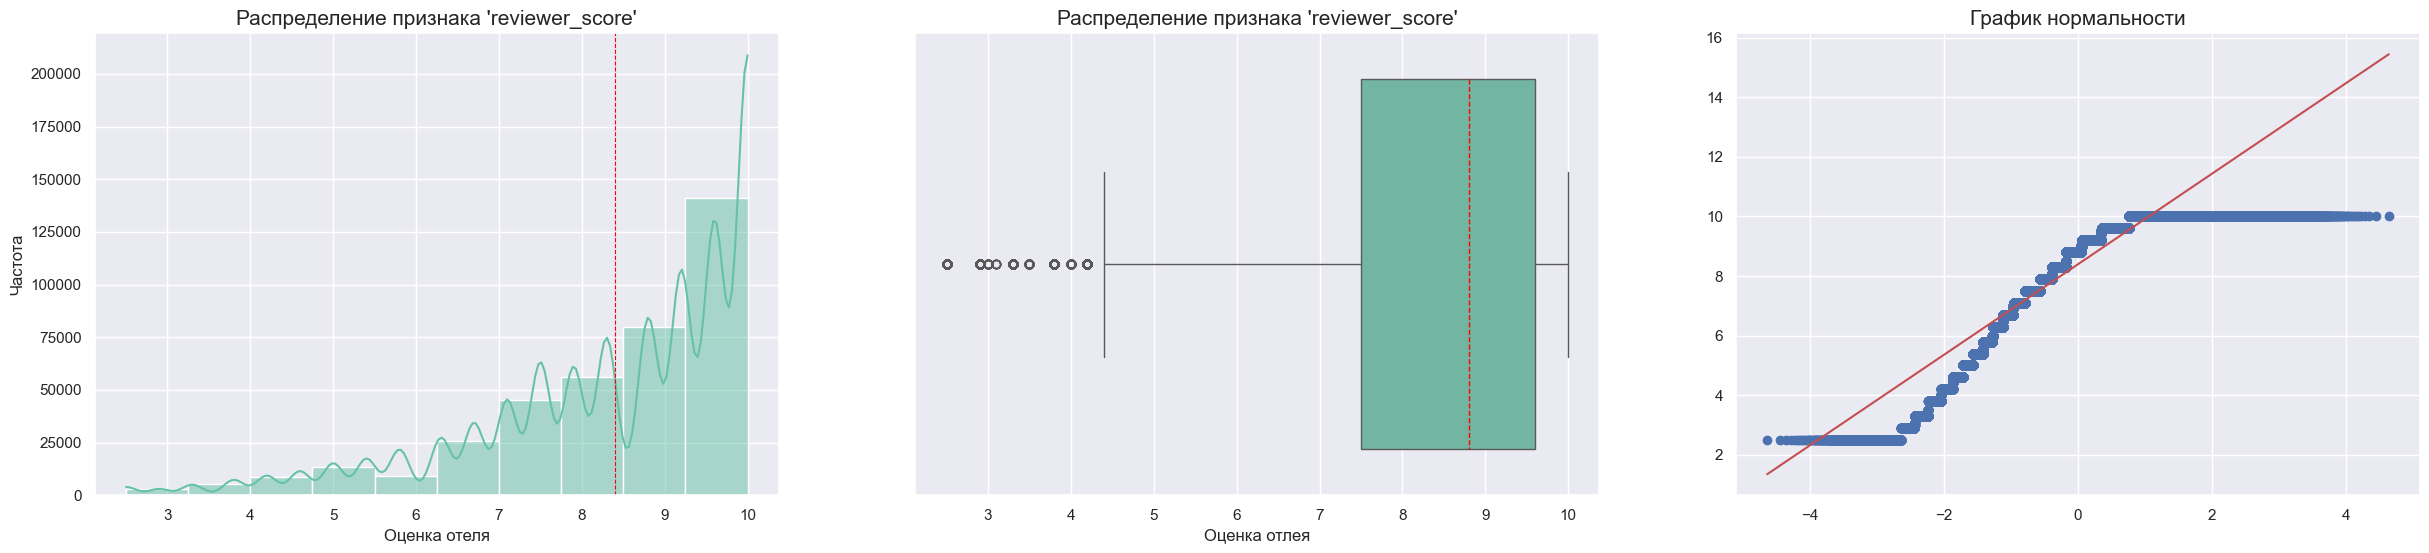

In [83]:
# Осуществляем визуализацию распределения числового признака оценки отеля.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['reviewer_score'], kde=True, ax=axes[0], bins=10)
axes[0].set_title("Распределение признака 'reviewer_score'", fontsize=15)
axes[0].set(xlabel='Оценка отеля', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['reviewer_score'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['reviewer_score'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Оценка отлея')
axes[1].set_title("Распределение признака 'reviewer_score'", fontsize=15)

stats.probplot(data[data['sample']==1]['reviewer_score'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [84]:
# Задаем уровень значимости.
alpha = 0.05

# Функция для принятия решения о нормальности.
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
        
        
# Проводим тест Шапиро-Уилка
print(colored('Для целевого признака `reviewer_score`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['reviewer_score'])
decision_normality(result[1])

Для целевого признака `reviewer_score`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Вывод по признаку `reviewer_score`:**

Данный признак можно расценивать и как категориальный, и как непрерывный (числовой), который имеет ненормальное распределение. Т.к. данный признак в дальнейшем не будет участвовать на проверку влияния на самого себя – не добавляем его в список признаков `num_cols`.

## Признак `hotel_address`

In [85]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['hotel_address'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['hotel_address'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['hotel_address'].nunique(), sep='\n')

,hotel_address
count,515738
unique,1493
top,163 Marsh Wall Docklands Tower Hamlets London ...
freq,4789



Тип данных признака:
object

Количество уникальных значений:
1493


In [86]:
print(colored(f'Формат вывода признака в строке:', 'green'))
data['hotel_address'][0]

Формат вывода признака в строке:


'Via Senigallia 6 20161 Milan Italy'

С учетом того, что уникальных адресов отелей в датасете почти **1 500** – сам по себе искомый признак вряд ли сможет оказать положительное воздействие на нашу предсказательную модель в дальнейшем, однако из данного признака возможно получить новые, более полезные признаки (посредством ***Feature Engineering***), а именно страна и город нахождения отеля.

In [87]:
# Копируем искомый датасет для безопасного добавления нового признака и добавляем новый признак страны отеля.
data_copy = data.copy()
data_copy['hotel_country'] = data_copy['hotel_address'].apply(lambda x: x.split(' ')[-1] \
                                                              if x.split(' ')[-1]!='Kingdom' else x.split(' ')[-2]+' '+x.split(' ')[-1])

# Отображаем процентное соотношение стран отелей в датасете.
print(colored(f'Процентное соотношение стран отлей:', 'green'))
display(round(data_copy['hotel_country'].value_counts(normalize=True)*100, 1))
# Вносим изменения в искомый датасет.
data = data_copy

Процентное соотношение стран отлей:


hotel_country
United Kingdom    50.9
Spain             11.7
France            11.6
Netherlands       11.1
Austria            7.6
Italy              7.2
Name: proportion, dtype: float64

In [88]:
# Копируем искомый датасет для безопасного добавления нового признака и добавляем новый признак города отеля.
data_copy = data.copy()
data_copy['hotel_city'] = data_copy['hotel_address'].apply(lambda x: x.split(' ')[-2] \
                                                           if x.split(' ')[-1]!='Kingdom' else x.split(' ')[-5]) # индекс -5 использован из-за специфика адреса в UK.

# Отображаем процентное соотношение городов отелей в датасете.
print(colored(f'Процентное соотношение городов отлей:', 'green'))
display(round(data_copy['hotel_city'].value_counts(normalize=True)*100, 1))
# Вносим изменения в искомый датасет.
data = data_copy

Процентное соотношение городов отлей:


hotel_city
London       50.9
Barcelona    11.7
Paris        11.6
Amsterdam    11.1
Vienna        7.6
Milan         7.2
Name: proportion, dtype: float64

**Примечание:**  
Как мы видим, новые признаки города и страны отеля полностью совпадают по количеству, т.е. какждой стране соответствует только один город, что свидетельствует о мультиколлинеарности данных признаков, что мы подтвердим далее в ходе этапа *Feature Sellection*.

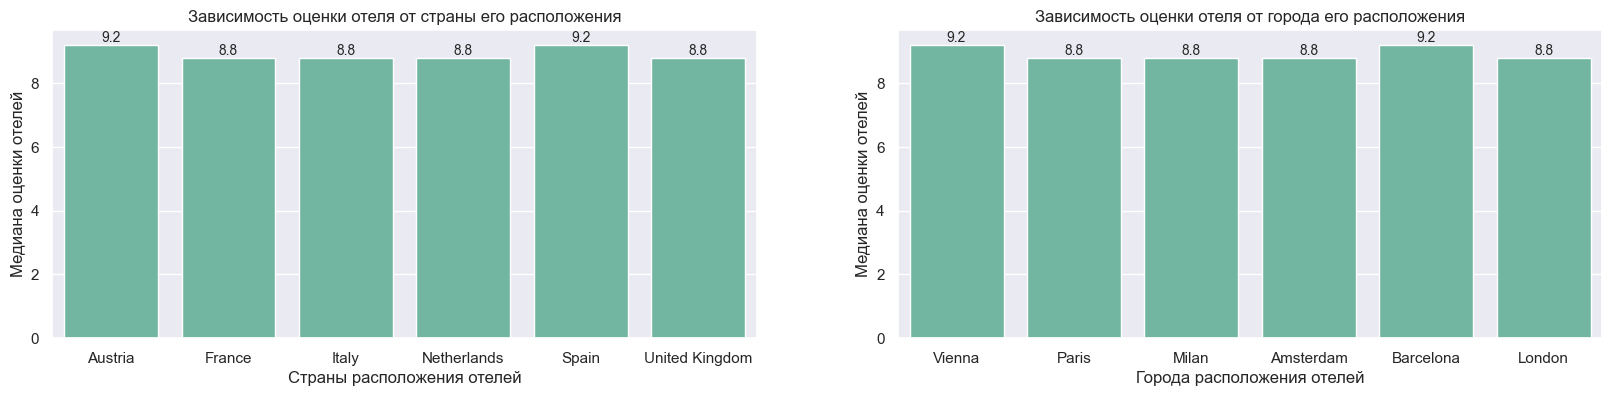

In [89]:
# Визуализируем зависимость оценки отеля от страны и города его расположения через столбчатые диаграммы.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))

sns.barplot(data=data[data['sample']==1].groupby('hotel_country', as_index=False)['reviewer_score'].median(), \
            x='hotel_country', y='reviewer_score', order=['Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom'], ax=axes[0])
axes[0].set(xlabel='Страны расположения отелей', ylabel='Медиана оценки отелей')
axes[0].bar_label(axes[0].containers[0], fontsize=10)
axes[0].set_title('Зависимость оценки отеля от страны его расположения')

sns.barplot(data=data[data['sample']==1].groupby('hotel_city', as_index=False)['reviewer_score'].median(), \
            x='hotel_city', y='reviewer_score', order=['Vienna', 'Paris', 'Milan', 'Amsterdam', 'Barcelona', 'London'], ax=axes[1])
axes[1].set(xlabel='Города расположения отелей', ylabel='Медиана оценки отелей')
axes[1].bar_label(axes[1].containers[0], fontsize=10)
axes[1].set_title('Зависимость оценки отеля от города его расположения');

**Выводы по признаку `hotel_address` и побочным признакам `hotel_country`, `hotel_city`:**

В результате анализа признака адреса гостиницы, который имеет строковый формат (*str/object*) посредством *Feature Engineering*'а созданы новые два признака страны расположения отеля `hotel_country` и города `hotel_city` соответсвенно, по результатам визуального анализа которых предварительно можно сделать вывод об их взаимной мультиколлениарности (высокая степень взаимной корреляции), а также о слабом влиянии на целевой признак оценки отеля `reviewer_score`. Исходный признак адреса может быть удален из датасета, а один из мультиколлениарных признаков страны и города отеля кодируем (*Feature Coding*) посредством однократного кодирования (*OneHotEncoding*) и также удаляем исходные признаки.

In [90]:
# Копируем искомый датасет.
data_copy = data.copy()

# Посредством однократного кодирования создаем новые признаки по странам и городам отелей.
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
ohe_bin = encoder.fit_transform(data_copy['hotel_city'])
data_copy = pd.concat([data_copy, ohe_bin], axis=1)

# Удаляем исходные признаки и применяем изменения к основному датасету.
data_copy.drop(['hotel_address', 'hotel_country', 'hotel_city'], axis=1, inplace=True)
data = data_copy

In [91]:
# Добавляем новые признаки в список категориальных признаков.
cat_cols.extend(ohe_bin.columns)

## Признак `review date`

In [92]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['review_date'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['review_date'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['review_date'].nunique(), sep='\n')

,review_date
count,515738
unique,731
top,8/2/2017
freq,2585



Тип данных признака:
object

Количество уникальных значений:
731


Первоначально требуется перевести данный признак из типа данных *object* в тип данных временного формата *datetime* для последующего извлечения производных признаков таких как год и прочие признаки:

In [93]:
# Приводим признак к формату datetime.
data['review_date'] = pd.to_datetime(data['review_date'])

In [94]:
# Функция для определения сезона отзыва.
def season_fill_func(date):
    """
    Функция для заполнения сезона оставленного отзыва с привязкой к его дате `review_date`.
    Args:
        date (datetime64): дата отзыва.

    Returns:
        int: сезон отзыва (уже с порядковым кодированием: 1 - зима, 2 - весна, 3 - лето, 4 - осень).
    """
    # Словарь-привязка сезона к порядковому номеру месяца.
    season_dict = {'Winter': [12, 1, 2],
                  'Spring': [3, 4, 5],
                  'Summer': [6, 7, 8],
                  'Autumn': [9, 10, 11]}
    # Вычленяем месяц отзыва.
    month = date.month
    # Определение сезона отзыва через соответствующий словарь с месяцами.
    if month in season_dict['Winter']:
        return 1
    elif month in season_dict['Spring']:
        return 2
    elif month in season_dict['Summer']:
        return 3
    else:
        return 4


# Копируем искомый датасет и создаем новый признак года отзыва.
data_copy = data.copy()
data_copy['review_year'] = data_copy['review_date'].apply(lambda x: x.year)

# Создаем признак сезона отзыва (уже с порядковым кодированием).
data_copy['review_season'] = data_copy['review_date'].apply(season_fill_func)

# Удаляем первоначальный признак 'review_date' как утративший значение.
data_copy.drop('review_date', axis=1, inplace=True)

# Применяем изменения к основному датасету.
data = data_copy

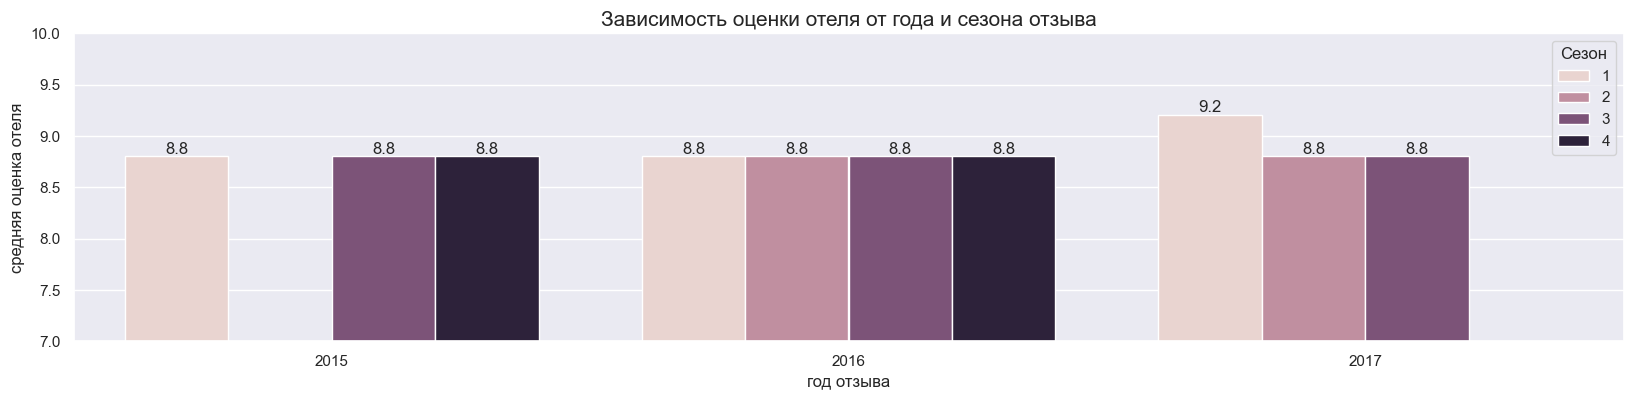

In [95]:
# Визуализация зависимости оценки отеля от года и сезона отзыва посредством столбчатой диаграммы. 
fig = plt.figure(figsize=(20,4))

plot = sns.barplot(data=data[data['sample']==1].groupby(['review_year', 'review_season'], \
                   as_index=False)['reviewer_score'].median(), \
                   x='review_year', y='reviewer_score', hue='review_season', hue_order=[1, 2, 3, 4])
plot.set(xlabel='год отзыва', ylabel='средняя оценка отеля')
plot.set_title('Зависимость оценки отеля от года и сезона отзыва', fontsize=15)
plot.bar_label(plot.containers[0], fontsize=12)
plot.bar_label(plot.containers[1], fontsize=12)
plot.bar_label(plot.containers[2], fontsize=12)
plot.bar_label(plot.containers[3], fontsize=12)
plot.legend(title='Сезон')
plt.ylim(7,10);

**Выводы по признаку `review_date` и побочным признакам `review_year`, `review_season`:**

В результате анализа признака даты оставления отзыва, который после преобразования имеет формат *datetime*, посредством *Feature Engineering*'а созданы новые два признака: год оставления отзыва `review_year` и сезон `review_season` соответсвенно, по результатам визуального анализа которых предварительно можно сделать вывод, что ни год отзыва, ни сезон особого влияния на оценку отеля не играют. По итогу стадии *Feature Engineering* мы уже провели кодирование признаков в порядковый формат. Признак `review_date` удален как утративший значение для будущей модели.

In [96]:
# Добавляем новые признаки в список категориальных признаков.
cat_cols.extend(['review_year', 'review_season'])

## Признак `additional_number_of_scoring`
***(количество оценок без отзывов)***

In [97]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['additional_number_of_scoring'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['additional_number_of_scoring'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['additional_number_of_scoring'].nunique(), sep='\n')

,additional_number_of_scoring
count,515738.000000
mean,498.081836
std,500.538467
min,1.000000
25%,169.000000
50%,341.000000
75%,660.000000
max,2682.000000



Тип данных признака:
int64

Количество уникальных значений:
480


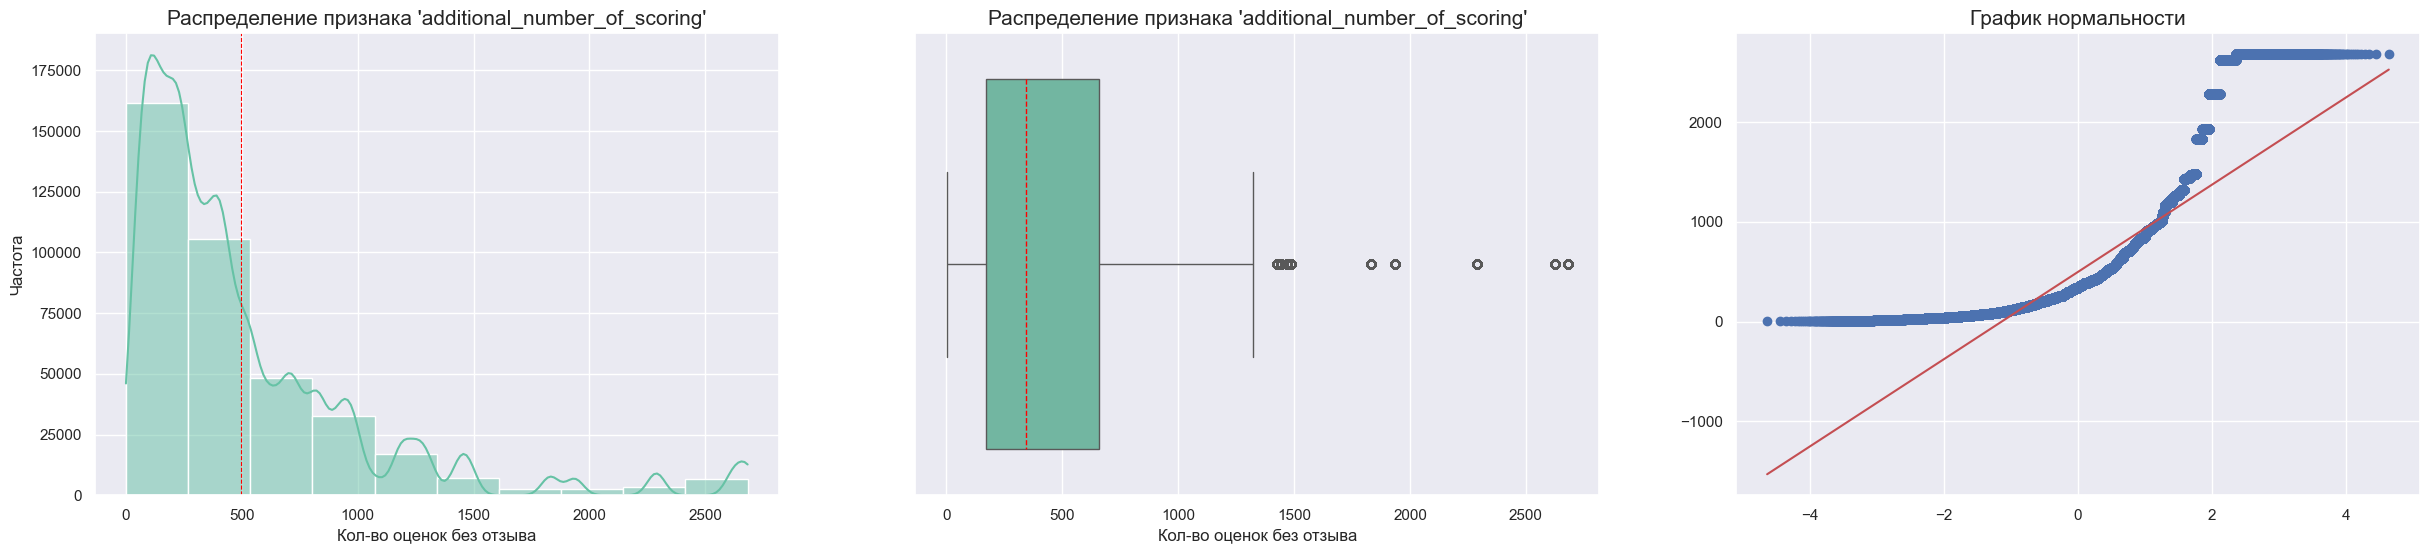

In [98]:
# Осуществляем визуализацию распределения числового признака количества оценок отеля без отзыва.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['additional_number_of_scoring'], kde=True, ax=axes[0], bins=10)
axes[0].set_title("Распределение признака 'additional_number_of_scoring'", fontsize=15)
axes[0].set(xlabel='Кол-во оценок без отзыва', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['additional_number_of_scoring'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['additional_number_of_scoring'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Кол-во оценок без отзыва')
axes[1].set_title("Распределение признака 'additional_number_of_scoring'", fontsize=15)

stats.probplot(data[data['sample']==1]['additional_number_of_scoring'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [99]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `additional_number_of_scoring`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['additional_number_of_scoring'])
decision_normality(result[1])

Для признака `additional_number_of_scoring`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


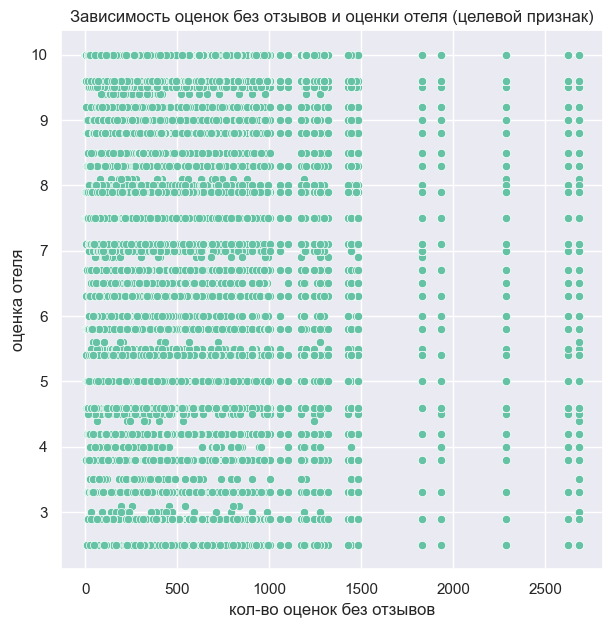

In [100]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='additional_number_of_scoring', y='reviewer_score')
plot.set(xlabel='кол-во оценок без отзывов', ylabel='оценка отеля')
plot.set_title('Зависимость оценок без отзывов и оценки отеля (целевой признак)');

**Вывод по признаку `additional_number_of_scoring`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено отсутствие взаимосвязи между данными признаками. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* с большой долей вероятности будет исключен из модели.

In [101]:
# Добавляем признак в список непрерывных признаков.
num_cols.append('additional_number_of_scoring')

## Признак `average_score`
***(средний балл отеля)***

In [102]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['average_score'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['average_score'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['average_score'].nunique(), sep='\n')

,average_score
count,515738.000000
mean,8.397487
std,0.548048
min,5.200000
25%,8.100000
50%,8.400000
75%,8.800000
max,9.800000



Тип данных признака:
float64

Количество уникальных значений:
34


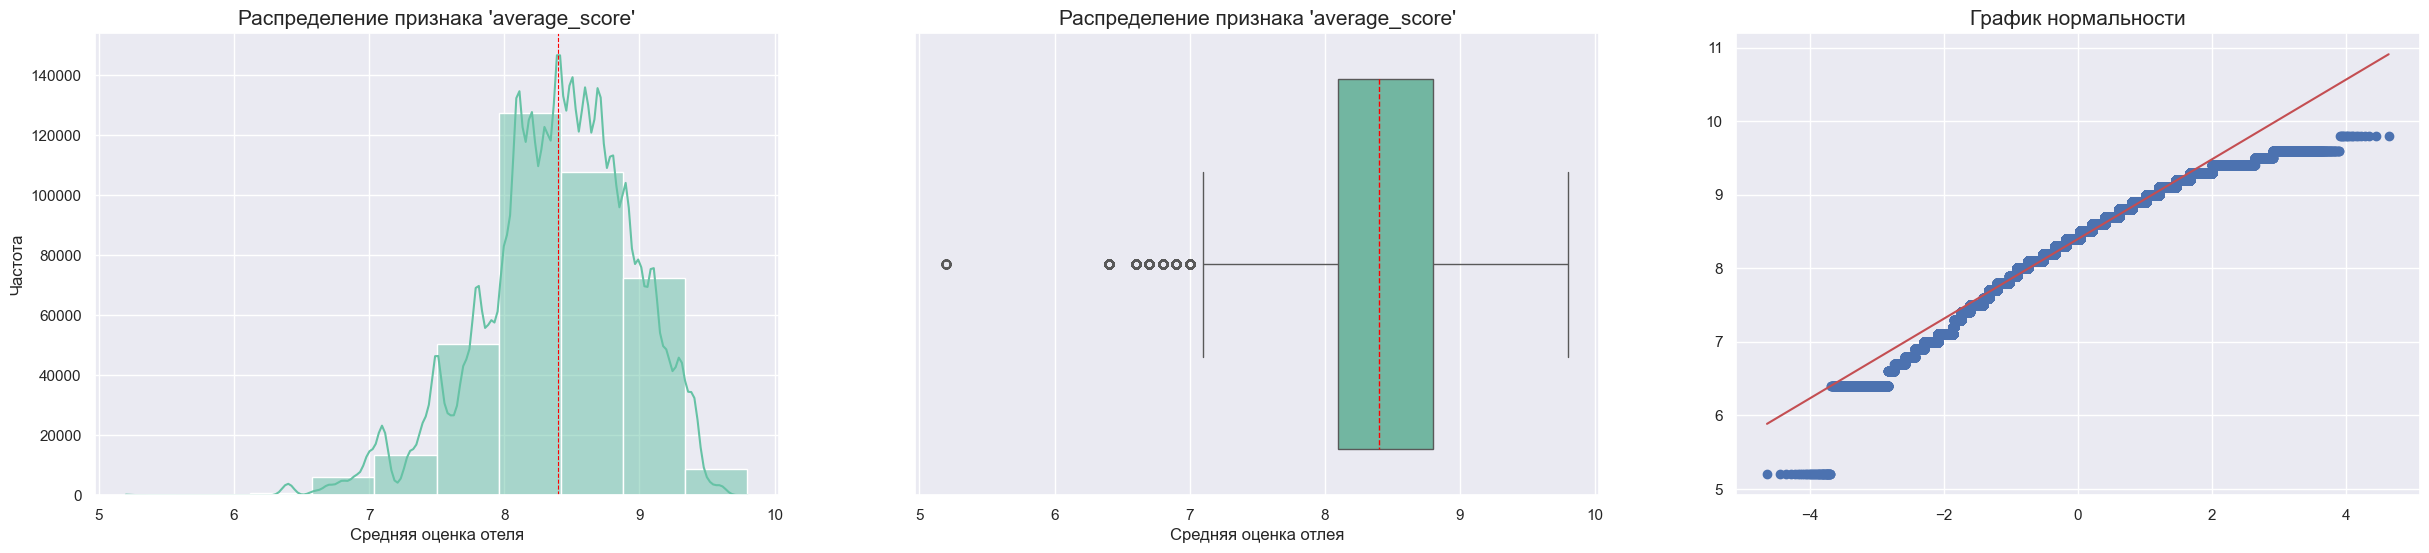

In [103]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['average_score'], kde=True, ax=axes[0], bins=10)
axes[0].set_title("Распределение признака 'average_score'", fontsize=15)
axes[0].set(xlabel='Средняя оценка отеля', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['average_score'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['average_score'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Средняя оценка отлея')
axes[1].set_title("Распределение признака 'average_score'", fontsize=15)

stats.probplot(data[data['sample']==1]['average_score'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [104]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `average_score`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['average_score'])
decision_normality(result[1])

Для признака `average_score`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


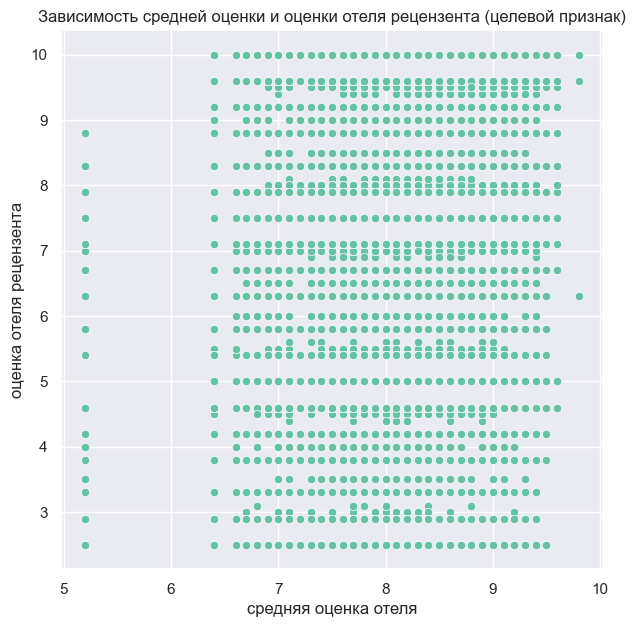

In [105]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='average_score', y='reviewer_score')
plot.set(xlabel='средняя оценка отеля', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость средней оценки и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `average_score`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет ненормальное распределение. Однако, как и целевой признак `reviewer_score`, данный признак имеет пограничное состояние с порядковым категориальным. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено отсутствие взаимосвязи между данными признаками или же она является очень слабой. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* с большой долей вероятности будет исключен из модели.

In [106]:
# Добавляем признак в список непрерывных признаков.
num_cols.append('average_score')

## Признак `hotel_name`

In [107]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['hotel_name'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['hotel_name'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['hotel_name'].nunique(), sep='\n')

,hotel_name
count,515738
unique,1492
top,Britannia International Hotel Canary Wharf
freq,4789



Тип данных признака:
object

Количество уникальных значений:
1492


**Вывод по признаку `hotel_name`:**

Данный признак имеет строковый тип данных (*str/object*) и сам по себе вряд ли способен нести какую бы то ни было значимость для будущей модели, а также не позволяет вычленить из него иные полезные признаки, в отличие от ранее рассмотренного признака `hotel_address`, который был успешно использован в рамках *Feature Engineering'*а. На основании изложенного принято решение удалить из даьасета данный неинформативный признак.

In [108]:
# Удаление строкового признака.
data.drop('hotel_name', axis=1, inplace=True)

## Признак `reviewer_nationality`

In [109]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['reviewer_nationality'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['reviewer_nationality'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['reviewer_nationality'].nunique(), sep='\n')

,reviewer_nationality
count,515738
unique,227
top,United Kingdom
freq,245246



Тип данных признака:
object

Количество уникальных значений:
227


In [110]:
# Находим 5 самых распостраненных гражданств среди рецензентов.
print(colored('Топ 5 гражданств рецензентов:', 'green'))
pd.DataFrame(round(data['reviewer_nationality'].value_counts(normalize=True)*100,1)).head(5)

Топ 5 гражданств рецензентов:


,proportion
reviewer_nationality,
United Kingdom,47.6
United States of America,6.9
Australia,4.2
Ireland,2.9
United Arab Emirates,2.0


In [111]:
# Инициируем список 5 самых популярных гражданств среди рецензентов.
top_citizen = [' United Kingdom ', ' United States of America ', ' Australia ', ' Ireland ', ' United Arab Emirates ']

# Копируем исходный датасет и оставляем в признаке 5 популярных гражданств, а остальные обобщаем одной категорией.
data_copy = data.copy()
data_copy['reviewer_nationality'] = data_copy['reviewer_nationality'].apply(lambda x: 'other' if x not in top_citizen else x)

# Посредством однократного кодирования создаем новые признаки.
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True)
ohe_bins = encoder.fit_transform(data_copy['reviewer_nationality'])
data_copy = pd.concat([data_copy, ohe_bins], axis=1)

# Применяем изменения к основному датасету.
data = data_copy

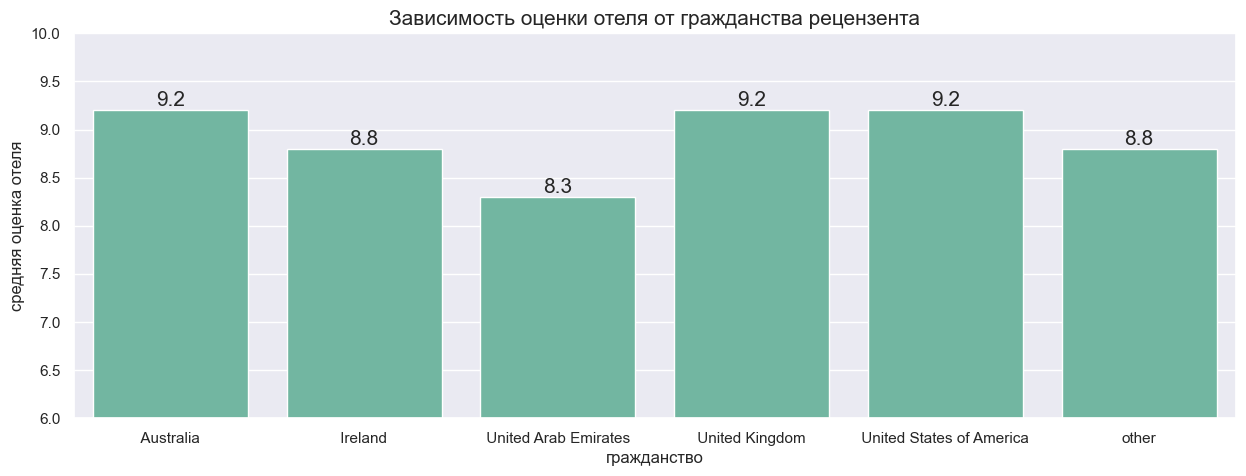

In [112]:
# Визуализация зависимости целевого признака от гражданства рецензента посредством столбчатой диаграммы. 
fig = plt.figure(figsize=(15,5))

plot = sns.barplot(data=data[data['sample']==1].groupby('reviewer_nationality', as_index=False)\
                   ['reviewer_score'].median(), x='reviewer_nationality', y='reviewer_score')
plot.set(xlabel='гражданство', ylabel='средняя оценка отеля')
plot.set_title('Зависимость оценки отеля от гражданства рецензента', fontsize=15)
plot.bar_label(plot.containers[0], fontsize=15)
plt.ylim(6,10);

In [113]:
# Удаляем исходный признак.
data.drop('reviewer_nationality', axis=1, inplace=True)

**Вывод по признаку `reviewer_nationality`:**

Данный признак можно расценивать как категориальный, который был преобразован посредством *Feature Engineering'*а и *Feature Coding'*а в 6 новых бинарных категориальных признаков. По результатам визуального анализа корреляции с целевым признаком предварительно выявлена очень слабая взаимосвязь. Производные признаки добавляем список признаков `cat_cols`.

In [114]:
# Добавляем новые признаки в список категориальных.
cat_cols.extend(ohe_bins.columns)

## Признаки `negative_review`, `positive_review` и смежные с ними `review_total_negative_word_counts`, `review_total_positive_word_counts`.

In [115]:
# Отображаем основные описательные характеристики для строковых признаков.
display(pd.DataFrame(data[['negative_review', 'positive_review']].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['negative_review'].dtype, \
      data['positive_review'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), \
      data[['negative_review', 'positive_review']].nunique(), sep='\n')
print()

# И для непрерывных признаков.
display(pd.DataFrame(data[['review_total_negative_word_counts', \
                           'review_total_positive_word_counts']].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['review_total_negative_word_counts'].dtype, \
      data['review_total_positive_word_counts'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), \
      data[['review_total_negative_word_counts', 'review_total_positive_word_counts']].nunique(), sep='\n')

,negative_review,positive_review
count,515738,515738
unique,330011,412601
top,No Negative,No Positive
freq,127890,35946



Тип данных признака:
object
object

Количество уникальных значений:
negative_review    330011
positive_review    412601
dtype: int64



,review_total_negative_word_counts,review_total_positive_word_counts
count,515738.000000,515738.000000
mean,18.539450,17.776458
std,29.690831,21.804185
min,0.000000,0.000000
25%,2.000000,5.000000
50%,9.000000,11.000000
75%,23.000000,22.000000
max,408.000000,395.000000



Тип данных признака:
int64
int64

Количество уникальных значений:
review_total_negative_word_counts    402
review_total_positive_word_counts    365
dtype: int64


In [116]:
# Отображение строковых признаков.
print(colored(f'Формат вывода признаков в строке:', 'green'), colored('Отрицательный отзыв:', 'yellow'), \
      data['negative_review'][0], colored('Положительный отзыв:', 'yellow'), data['positive_review'][0], sep='\n')

Формат вывода признаков в строке:
Отрицательный отзыв:
 Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices 
Положительный отзыв:
 Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again 


Сами по себе в исходном виде признаки `negative_review` и `positive_review` как строковые (*str/object*) не способны быть полезными для выстраиваемой модели. Однако смежные с ними непрерывные признаки `review_total_negative_word_counts` и `review_total_positive_word_counts` показывают как раз необходимые нам показатели количества слов с негативным и положительным окрасом в соответствующих отзывах. Таким образом, вышеуказанные строковые признаки могут быть удалены из датасета.

In [117]:
# Удаляем строковые признаки.
data.drop(['negative_review', 'positive_review'], axis=1, inplace=True)

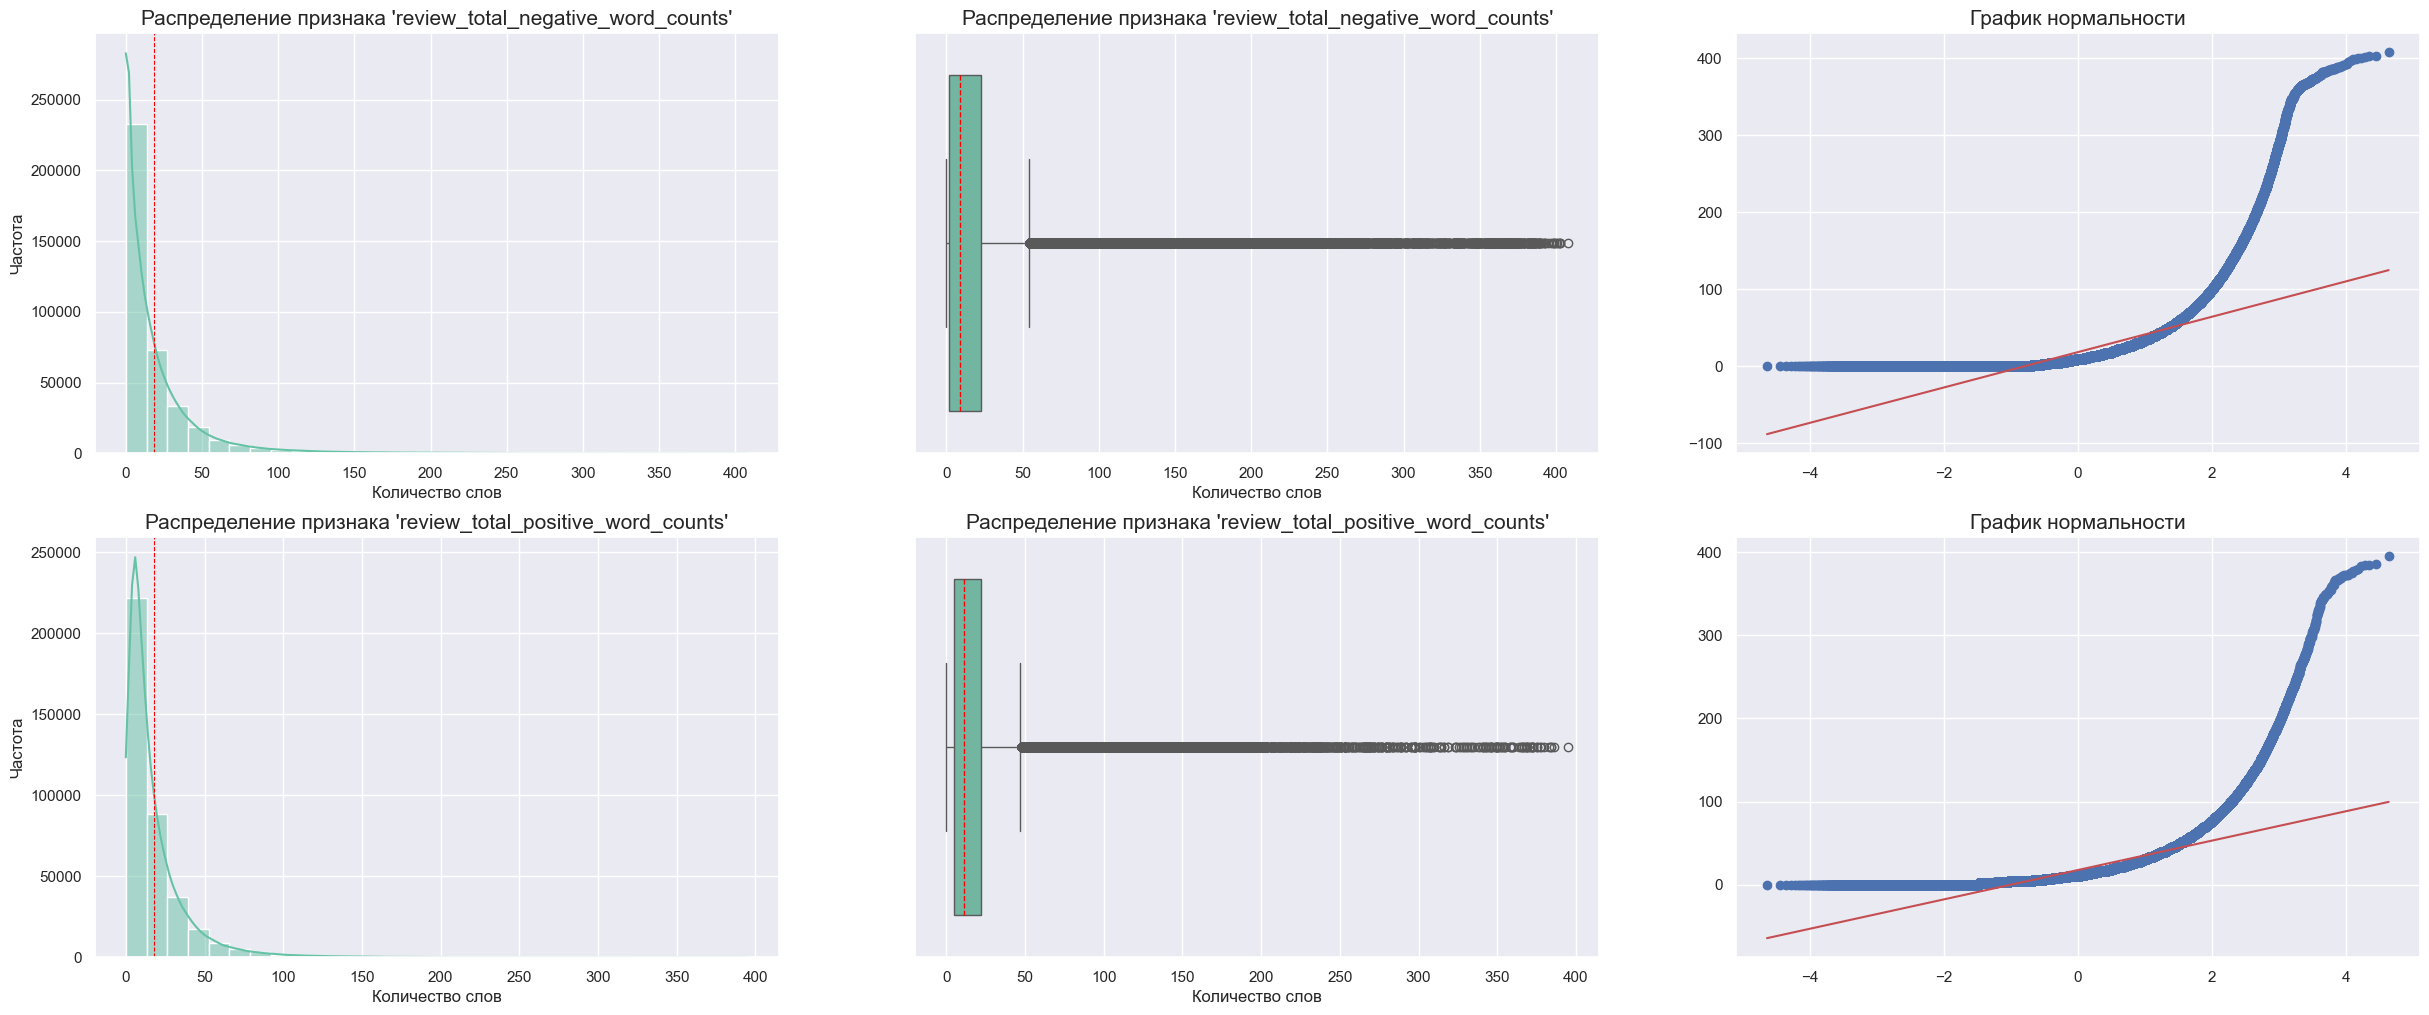

In [118]:
# Осуществляем визуализацию распределения числовых признаков.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,12))

sns.histplot(data=data[data['sample']==1]['review_total_negative_word_counts'], kde=True, ax=axes[0,0], bins=30)
axes[0,0].set_title("Распределение признака 'review_total_negative_word_counts'", fontsize=15)
axes[0,0].set(xlabel='Количество слов', ylabel='Частота')
axes[0,0].axvline(data[data['sample']==1]['review_total_negative_word_counts'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['review_total_negative_word_counts'], ax=axes[0,1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[0,1].set(xlabel='Количество слов')
axes[0,1].set_title("Распределение признака 'review_total_negative_word_counts'", fontsize=15)

stats.probplot(data[data['sample']==1]['review_total_negative_word_counts'], plot=axes[0,2])
axes[0,2].set(xlabel='', ylabel='')
axes[0,2].set_title('График нормальности', fontsize=15)


sns.histplot(data=data[data['sample']==1]['review_total_positive_word_counts'], kde=True, ax=axes[1,0], bins=30)
axes[1,0].set_title("Распределение признака 'review_total_positive_word_counts'", fontsize=15)
axes[1,0].set(xlabel='Количество слов', ylabel='Частота')
axes[1,0].axvline(data[data['sample']==1]['review_total_positive_word_counts'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['review_total_positive_word_counts'], ax=axes[1,1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1,1].set(xlabel='Количество слов')
axes[1,1].set_title("Распределение признака 'review_total_positive_word_counts'", fontsize=15)

stats.probplot(data[data['sample']==1]['review_total_positive_word_counts'], plot=axes[1,2])
axes[1,2].set(xlabel='', ylabel='')
axes[1,2].set_title('График нормальности', fontsize=15);

Согласно полученным данным визуального анализа вышеуказанных признаков они явно не имеют нормального распределения, но формально проверим данные наблюдения посредством теста: 

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [119]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `review_total_negative_word_counts`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['review_total_negative_word_counts'])
decision_normality(result[1])
print()
print(colored('Для признака `review_total_positive_word_counts`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['review_total_positive_word_counts'])
decision_normality(result[1])

Для признака `review_total_negative_word_counts`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для признака `review_total_positive_word_counts`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


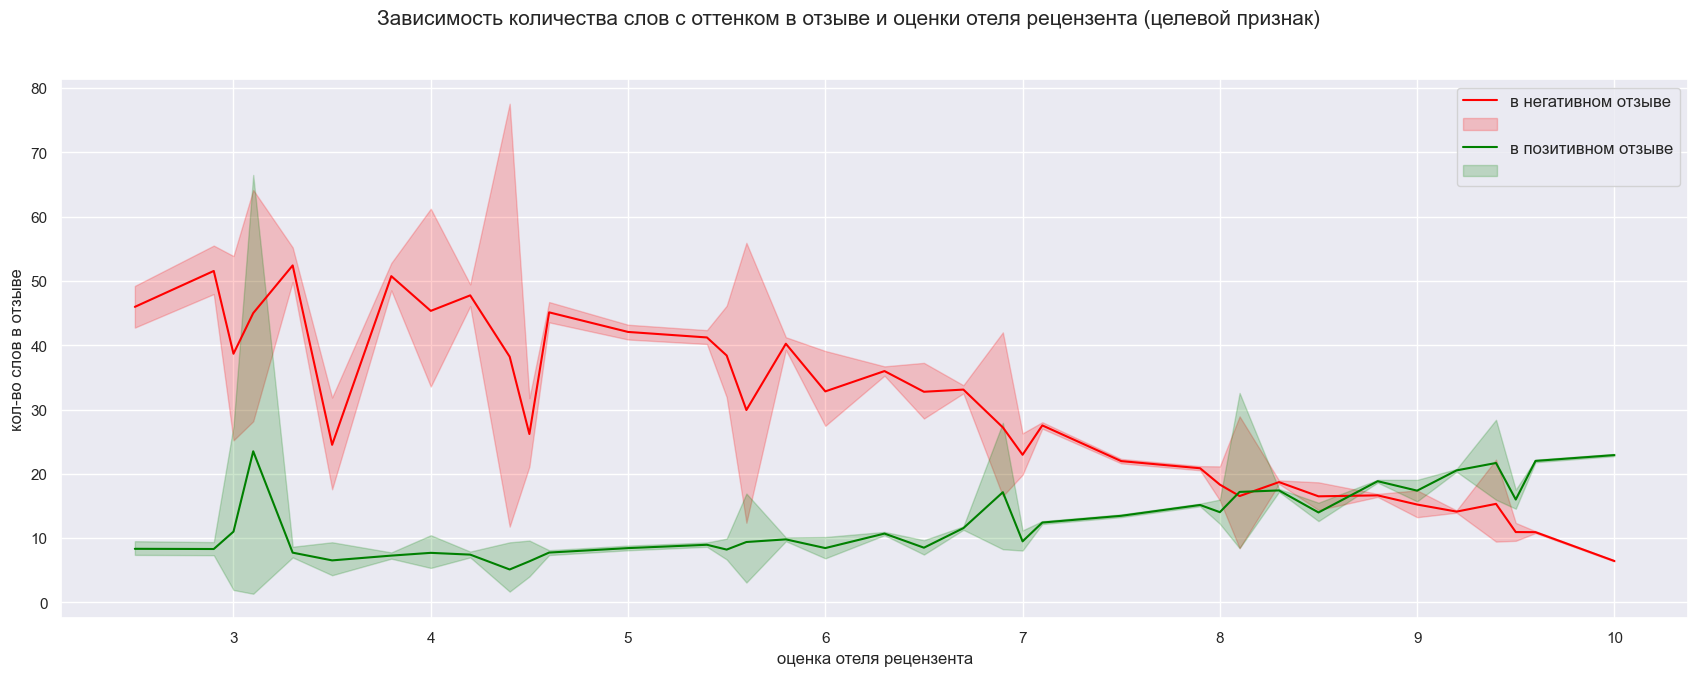

In [120]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(21,7))
fig.suptitle('Зависимость количества слов c оттенком в отзыве и оценки отеля рецензента (целевой признак)', fontsize=15)

plot_neg = sns.lineplot(data=data[data['sample']==1], x='reviewer_score', y='review_total_negative_word_counts', color='red')
plot_neg.set(xlabel='оценка отеля рецензента', ylabel='кол-во слов в отзыве')

plot_pos = sns.lineplot(data=data[data['sample']==1], x='reviewer_score', y='review_total_positive_word_counts', color='green')
plot_pos.set(xlabel='оценка отеля рецензента', ylabel='кол-во слов в отзыве')

plot_neg.legend(['в негативном отзыве', '', 'в позитивном отзыве', ''], fontsize=12);

**Вывод по признакам `review_total_negative_word_counts` и `review_total_positive_word_counts`:**

Данные признаки можно расценивать как непрерывные (числовые), которые имеют ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлена слабая взаимосвязь между данными признаками и целевым (обратная и прямая соответственно). Данные признаки добавляем в список признаков `num_cols`, которые на дальнейшем этапе *Feature Sellection* будут дополнительно проверены на значимость для модели.

In [121]:
# Добавляем признаки в список непрерывных.
num_cols.extend(['review_total_negative_word_counts', 'review_total_positive_word_counts'])

**Создаем новый признак на основе `review_total_negative_word_counts`, `review_total_positive_word_counts`:**

Предлагается создать признак, отражающий пропорциональную зависимость количества положительных слов в отзыве и негативных слов.

In [122]:
# Копируем искомый датасет.
data_copy = data.copy()

# Заполняем нулевые значения признака негативных слов единицей во избежание получения np.inf в будущей пропорции.
data_copy['review_total_negative_word_counts'] = data_copy['review_total_negative_word_counts'].apply(lambda x: 1 if x == 0 else x)
# Получаем отношение количества слов полож. отзыва к негативному.
data_copy['review_total_positive_word_prop'] = round(data_copy['review_total_positive_word_counts'] / data_copy['review_total_negative_word_counts'], 2)
# Заполняем пропуски нового признака нулями.
data_copy['review_total_positive_word_prop'].fillna(0, inplace=True)

# Применяем изменения к основному датасету.
data = data_copy

In [123]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['review_total_positive_word_prop'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['review_total_positive_word_prop'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['review_total_positive_word_prop'].nunique(), sep='\n')

,review_total_positive_word_prop
count,515738.000000
mean,6.258396
std,13.745134
min,0.000000
25%,0.410000
50%,1.180000
75%,6.000000
max,384.000000



Тип данных признака:
float64

Количество уникальных значений:
1822


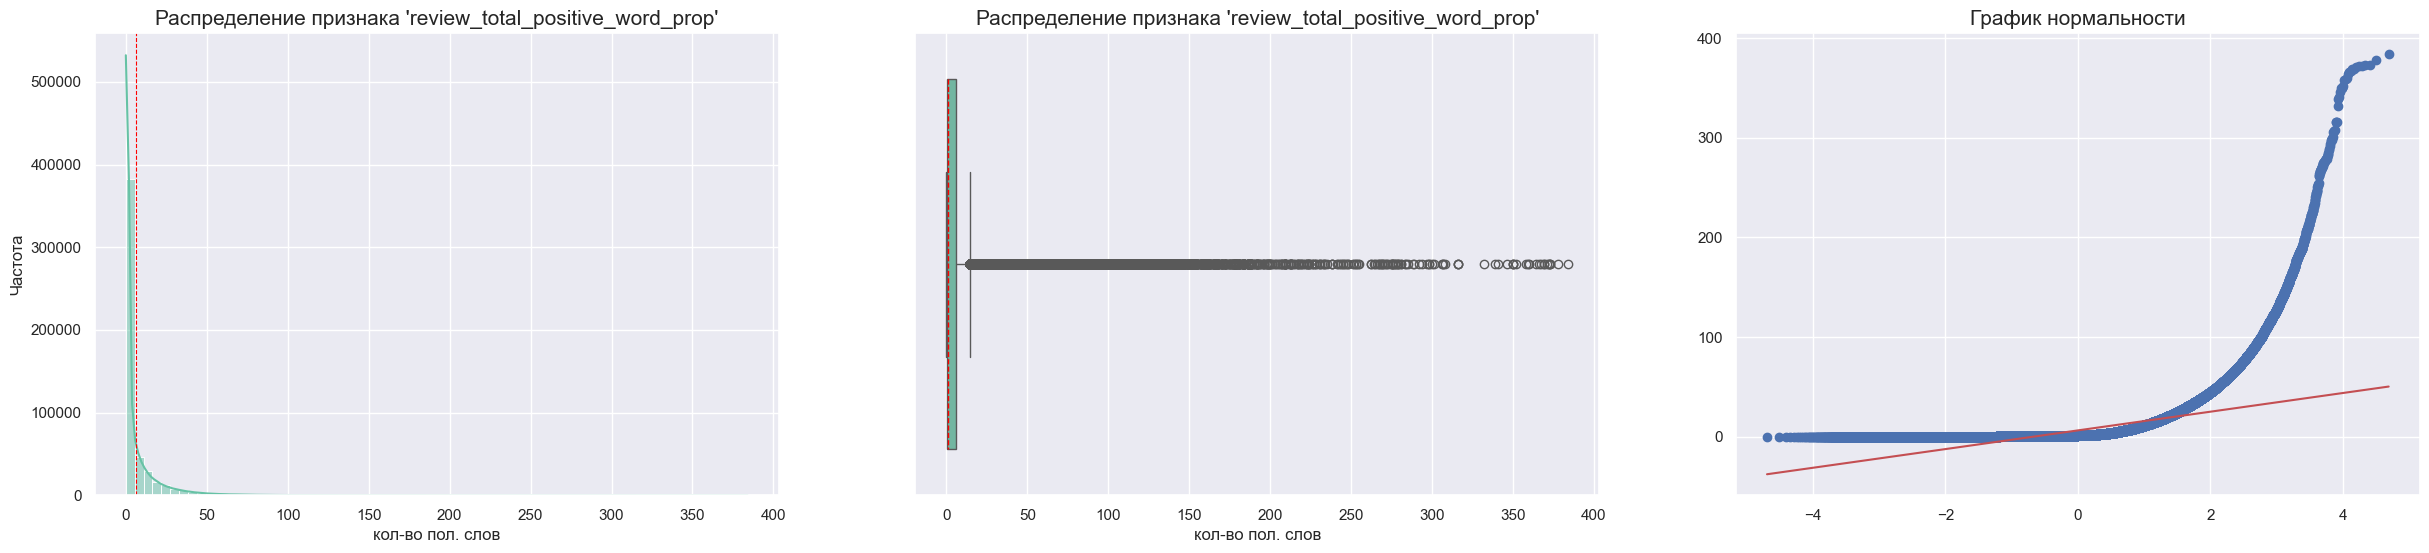

In [124]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data['review_total_positive_word_prop'], kde=True, ax=axes[0], bins=70)
axes[0].set_title("Распределение признака 'review_total_positive_word_prop'", fontsize=15)
axes[0].set(xlabel='кол-во пол. слов', ylabel='Частота')
axes[0].axvline(data['review_total_positive_word_prop'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['review_total_positive_word_prop'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='кол-во пол. слов')
axes[1].set_title("Распределение признака 'review_total_positive_word_prop'", fontsize=15)

stats.probplot(data['review_total_positive_word_prop'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

По результатам визуального анализа признака можно уже сделать явный вывод о его ненормальном распределении.

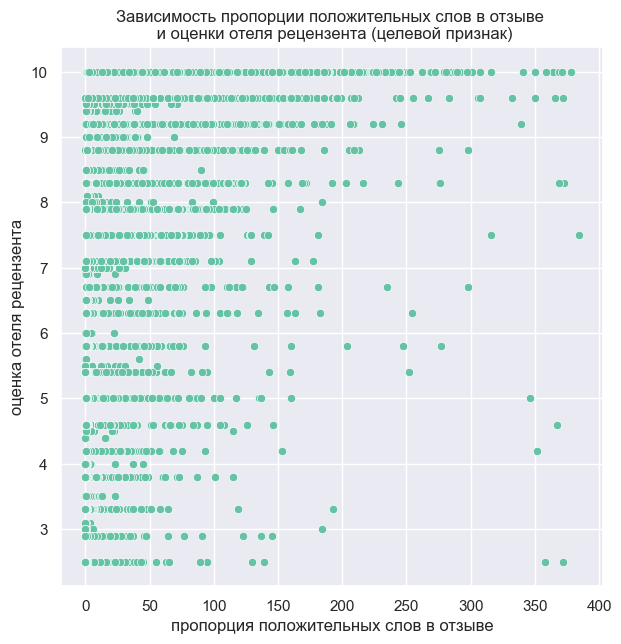

In [125]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='review_total_positive_word_prop', y='reviewer_score')
plot.set(xlabel='пропорция положительных слов в отзыве', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость пропорции положительных слов в отзыве \n и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `review_total_positive_word_prop`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет явное ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено наличие слабой прямой взаимосвязи между данными признаками. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* будет дополнительно проверен на свою значимость для модели.

In [126]:
# Добавляем признак в список непрерывных признаков.
num_cols.append('review_total_positive_word_prop')

## Признак `total_number_of_reviews`

In [127]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['total_number_of_reviews'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['total_number_of_reviews'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['total_number_of_reviews'].nunique(), sep='\n')

,total_number_of_reviews
count,515738.000000
mean,2743.743944
std,2317.464868
min,43.000000
25%,1161.000000
50%,2134.000000
75%,3613.000000
max,16670.000000



Тип данных признака:
int64

Количество уникальных значений:
1142


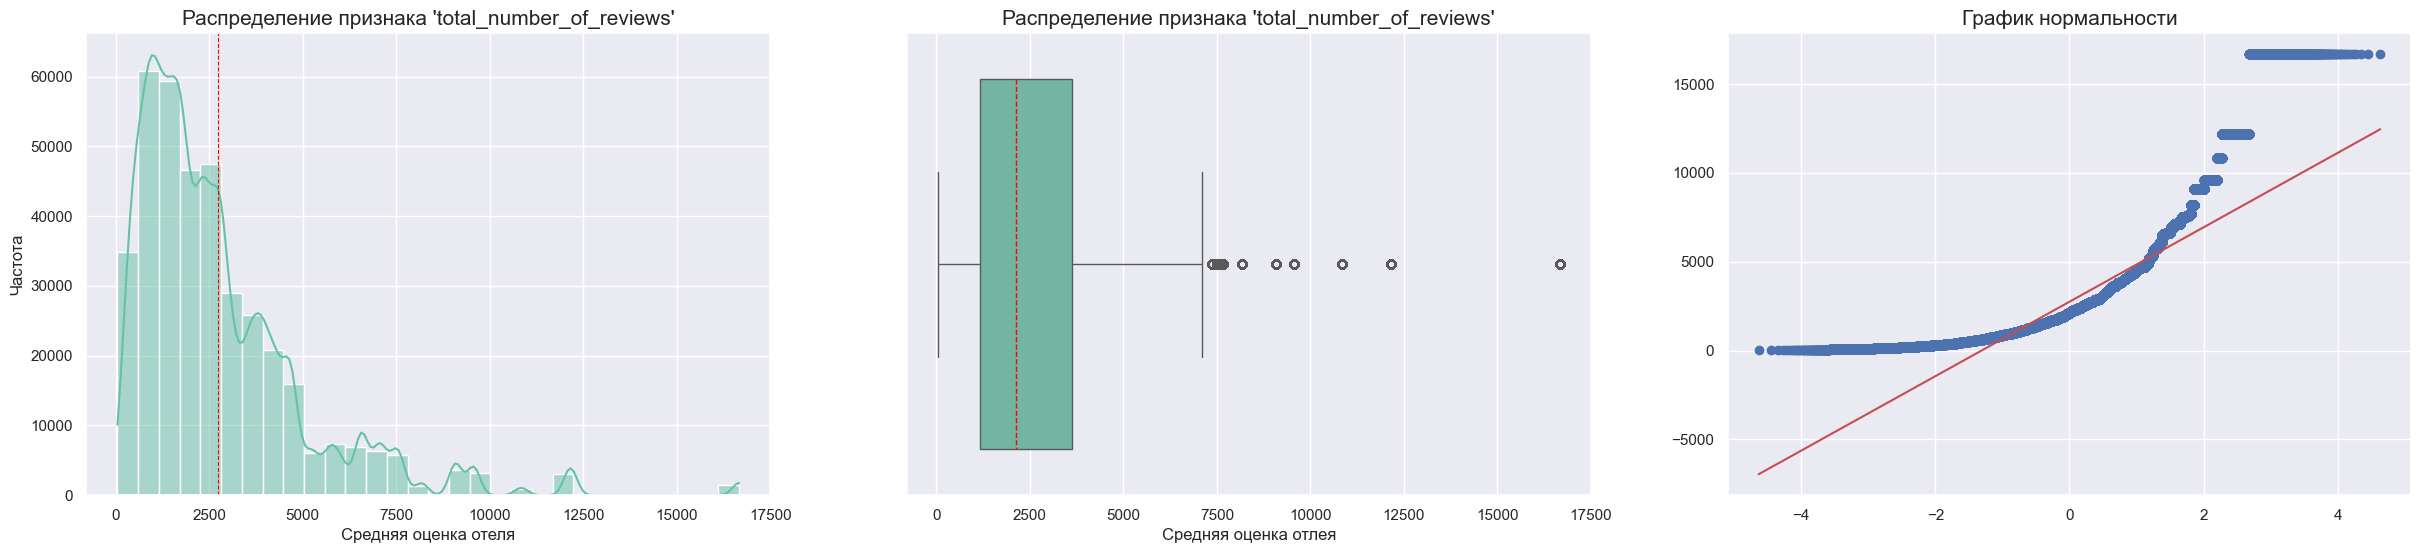

In [128]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['total_number_of_reviews'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Распределение признака 'total_number_of_reviews'", fontsize=15)
axes[0].set(xlabel='Средняя оценка отеля', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['total_number_of_reviews'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['total_number_of_reviews'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Средняя оценка отлея')
axes[1].set_title("Распределение признака 'total_number_of_reviews'", fontsize=15)

stats.probplot(data[data['sample']==1]['total_number_of_reviews'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

Согласно полученным данным визуального анализа вышеуказанного признака он явно не имеет нормального распределения, но формально проверим данные наблюдения посредством теста:

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [129]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `total_number_of_reviews`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['total_number_of_reviews'])
decision_normality(result[1])

Для признака `total_number_of_reviews`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


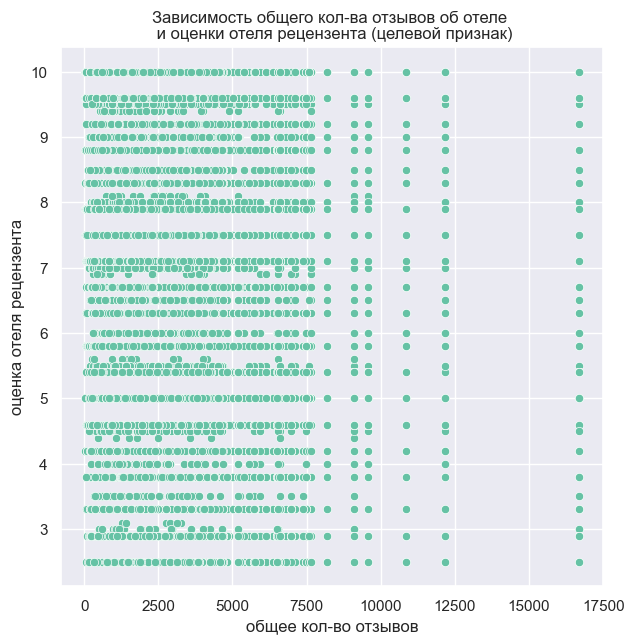

In [130]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='total_number_of_reviews', y='reviewer_score')
plot.set(xlabel='общее кол-во отзывов', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость общего кол-ва отзывов об отеле \n и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `total_number_of_reviews`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено отсутствие взаимосвязи между данными признаками или же она является очень слабой. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* с большой долей вероятности будет исключен из модели.

In [131]:
# Добавляем признаки в список непрерывных.
num_cols.append('total_number_of_reviews')

## Признак `tags`

In [132]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['tags'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['tags'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['tags'].nunique(), sep='\n')

,tags
count,515738
unique,55242
top,"[' Leisure trip ', ' Couple ', ' Double Room '..."
freq,5101



Тип данных признака:
object

Количество уникальных значений:
55242


In [133]:
# Отображаем формат вывода значений признака в строке.
print(colored('Формат вывода признака:', 'green'))
data['tags'][0]

Формат вывода признака:


"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

In [134]:
# Задаем функцию для приведения значений данного признака в итерируемый формат списка.
def get_tags_list(origin_tags):
    """
    Функция для преведения формата значений признака к итерируемому списку тэгов.
    Args:
        origin_tags (str): необработанный формат вывода тэгов.

    Returns:
        list: итерируемый список тэгов.
    """
    odd_symbols = ['[', ']', "'"]
    for symb in odd_symbols:
        origin_tags = origin_tags.replace(symb, '')
    return origin_tags.split(', ')


# Задаем функцию для создания списка уникальных тэгов.
def get_unique_tags(tags_list):
    """
    Функция для создания списка уникальных тэгов в отзывах.
    Args:
        tags_list (list): обработанный формат вывода тэгов.

    Returns:
        list: заполняет список уникальных тэгов `unique_tag_list`.
    """
    global unique_tag_list
    for tag in tags_list:
        if tag not in unique_tag_list:
            unique_tag_list.append(tag)
        
# Копируем искомый датасет.
data_copy = data.copy()
        
# Приводим признак тэгов в итерируемый формат.
data_copy['tags'] = data_copy['tags'].apply(get_tags_list)

# Создаем список уникальных тэгов и применяем функцию.
unique_tag_list = []
data_copy['tags'].apply(get_unique_tags)

# Выводим количество уникальных тэгов.
print(colored('Количество уникальных тэгов:', 'green'))
len(unique_tag_list)

Количество уникальных тэгов:


2428

In [135]:
# Задаем функцию для определения частоты тэгов.
def tag_count_func(tags_list):
    """
    Функция для определения частоты каждого тэга в датасете.
    Args:
        tags_list (list): обработанный формат вывода тэгов.

    Returns:
        dict: заполняет словарь-счетчик тэгов.
    """
    global tag_counter
    odd_symbols = ['[', ']', "'"]
    for tag in tags_list:
        if tag not in tag_counter:
            tag_counter[tag] = 1
        else:
            tag_counter[tag] += 1


# Задаем словарь-счетчик тегов и инициируем функцию.
tag_counter = {}
data_copy['tags'].apply(tag_count_func)

# Выводим топ 8 самых распространенных тэгов.
tags_series = pd.Series(tag_counter).sort_values(ascending=False)
print(colored('Топ 8 популярных тэгов:', 'green'), list(tags_series[:8].index), sep='\n')

Топ 8 популярных тэгов:
[' Leisure trip ', ' Submitted from a mobile device ', ' Couple ', ' Stayed 1 night ', ' Stayed 2 nights ', ' Solo traveler ', ' Stayed 3 nights ', ' Business trip ']


Посредством одинарного кодирования создадим новые признаки из самых популярных тэгов:

In [136]:
# Создаем новые бинарные категориальные признаки.
for tag in tags_series[:8].index:
    data_copy['tag' + tag] = data_copy['tags'].apply(lambda x: 1 if tag in x else 0)
    
# Удаляем исходный признак тэгов и неинформативный по отзыву с телефона,  вносим изменения в основной датасет.
data_copy.drop(['tags', 'tag Submitted from a mobile device '], axis=1, inplace=True)
data = data_copy

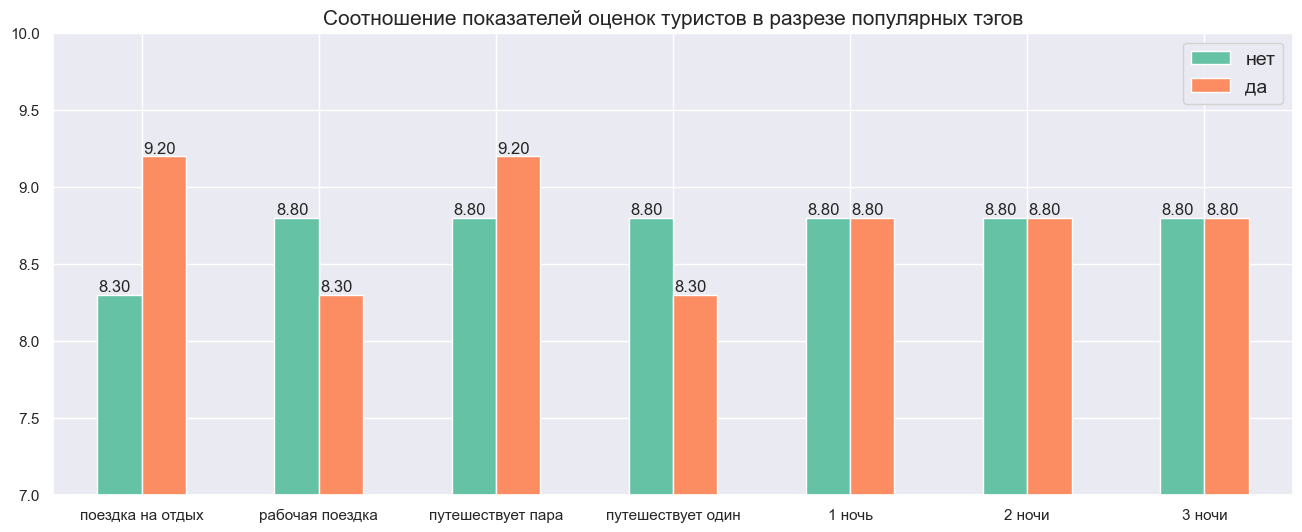

In [137]:
# Визуализация зависимости целевого признака от новых бинарных признаков столбчатой диаграммы. 
mask = data['sample'] == 1
pivot_lt = data[mask].groupby('tag Leisure trip ')['reviewer_score'].median()
pivot_bt = data[mask].groupby('tag Business trip ')['reviewer_score'].median()
pivot_couple = data[mask].groupby('tag Couple ')['reviewer_score'].median()
pivot_solo = data[mask].groupby('tag Solo traveler ')['reviewer_score'].median()
pivot_1_night = data[mask].groupby('tag Stayed 1 night ')['reviewer_score'].median()
pivot_2_nights = data[mask].groupby('tag Stayed 2 nights ')['reviewer_score'].median()
pivot_3_nights = data[mask].groupby('tag Stayed 3 nights ')['reviewer_score'].median()

pivot = pd.DataFrame({
    'поездка на отдых': pivot_lt,
    'рабочая поездка': pivot_bt,
    'путешествует пара': pivot_couple,
    'путешествует один': pivot_solo,
    '1 ночь': pivot_1_night,
    '2 ночи': pivot_2_nights,
    '3 ночи': pivot_3_nights
}).T

fig, axes = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=axes, 
    kind='bar',
    rot=0)
axes.set_title('Соотношение показателей оценок туристов в разрезе популярных тэгов', size=15)
axes.legend(['нет', 'да'], loc='upper right', fontsize=14)

for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=12)

plt.ylim(7, 10);


**Вывод по признаку `tags`:**

Данный признак можно расценивать как категориальный, который был преобразован посредством *Feature Engineering'*а и *Feature Coding'*а в 7 новых бинарных категориальных признаков. По результатам визуального анализа корреляции с целевым признаком предварительно взаимосвязь не выявлена. Производные признаки добавляем список признаков `cat_cols`.

In [138]:
# Добавляем новые признаки в список категориальных.
cat_cols.extend(data.columns[-7:])

## Признак `total_number_of_reviews_reviewer_has_given`

In [139]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['total_number_of_reviews_reviewer_has_given'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['total_number_of_reviews_reviewer_has_given'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['total_number_of_reviews_reviewer_has_given'].nunique(), sep='\n')

,total_number_of_reviews_reviewer_has_given
count,515738.000000
mean,7.166001
std,11.040228
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,355.000000



Тип данных признака:
int64

Количество уникальных значений:
198


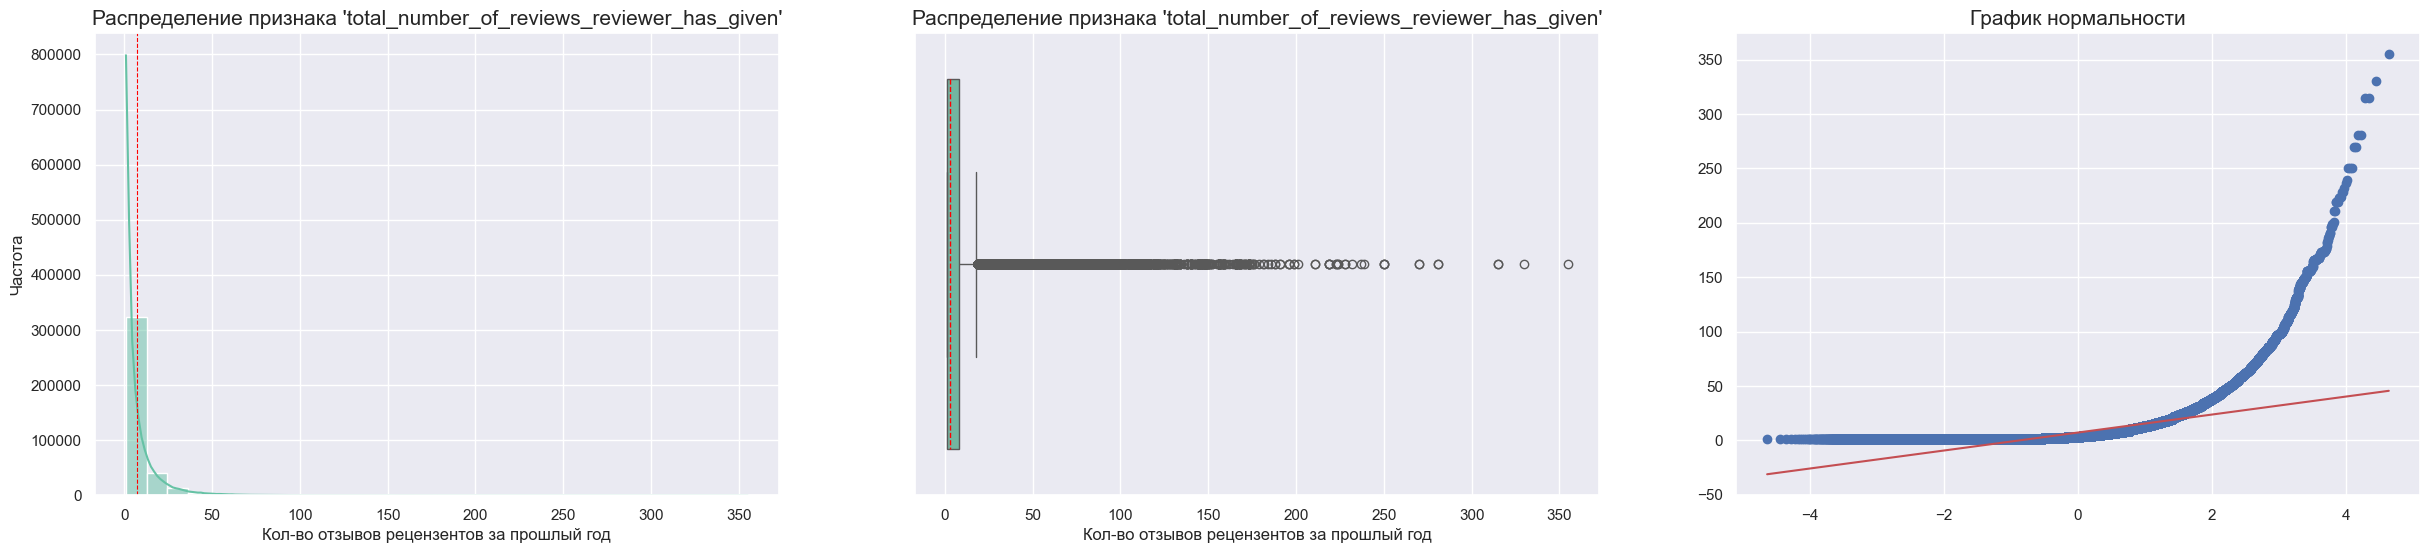

In [140]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['total_number_of_reviews_reviewer_has_given'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Распределение признака 'total_number_of_reviews_reviewer_has_given'", fontsize=15)
axes[0].set(xlabel='Кол-во отзывов рецензентов за прошлый год', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['total_number_of_reviews_reviewer_has_given'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['total_number_of_reviews_reviewer_has_given'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Кол-во отзывов рецензентов за прошлый год')
axes[1].set_title("Распределение признака 'total_number_of_reviews_reviewer_has_given'", fontsize=15)

stats.probplot(data[data['sample']==1]['total_number_of_reviews_reviewer_has_given'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

По результату визуального анализа признака можно сразу сделать вывод о его ненормальном распределении.

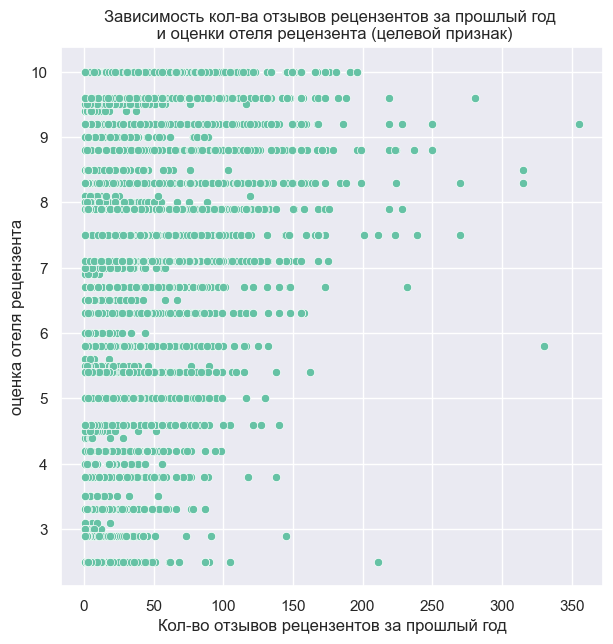

In [141]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='total_number_of_reviews_reviewer_has_given', y='reviewer_score')
plot.set(xlabel='Кол-во отзывов рецензентов за прошлый год', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость кол-ва отзывов рецензентов за прошлый год \n и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `total_number_of_reviews_reviewer_has_given`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет явное ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено наличие слабой прямой взаимосвязи между данными признаками. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* будет дополнительно проверен на свою значимость для модели.

In [142]:
# Добавляем признак в соответствующий список.
num_cols.append('total_number_of_reviews_reviewer_has_given')

## Признак `days_since_review`

In [143]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['days_since_review'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['days_since_review'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['days_since_review'].nunique(), sep='\n')

,days_since_review
count,515738
unique,731
top,1 days
freq,2585



Тип данных признака:
object

Количество уникальных значений:
731


По моему мнению, данный признак вряд ли может оказать хоть какое-то влияние на целевой, однако все же поработаем с ним. Данный признак требует его преобразование в числовой обычным отсечением слова *days*:

In [144]:
# Копируем искомы датасет.
data_copy = data.copy()
# Приводим признак к числовому значению.
data_copy['days_since_review'] = data_copy['days_since_review'].apply(lambda x: int(x.split()[0]))
# Применяем изменения к исходному датасету.
data = data_copy

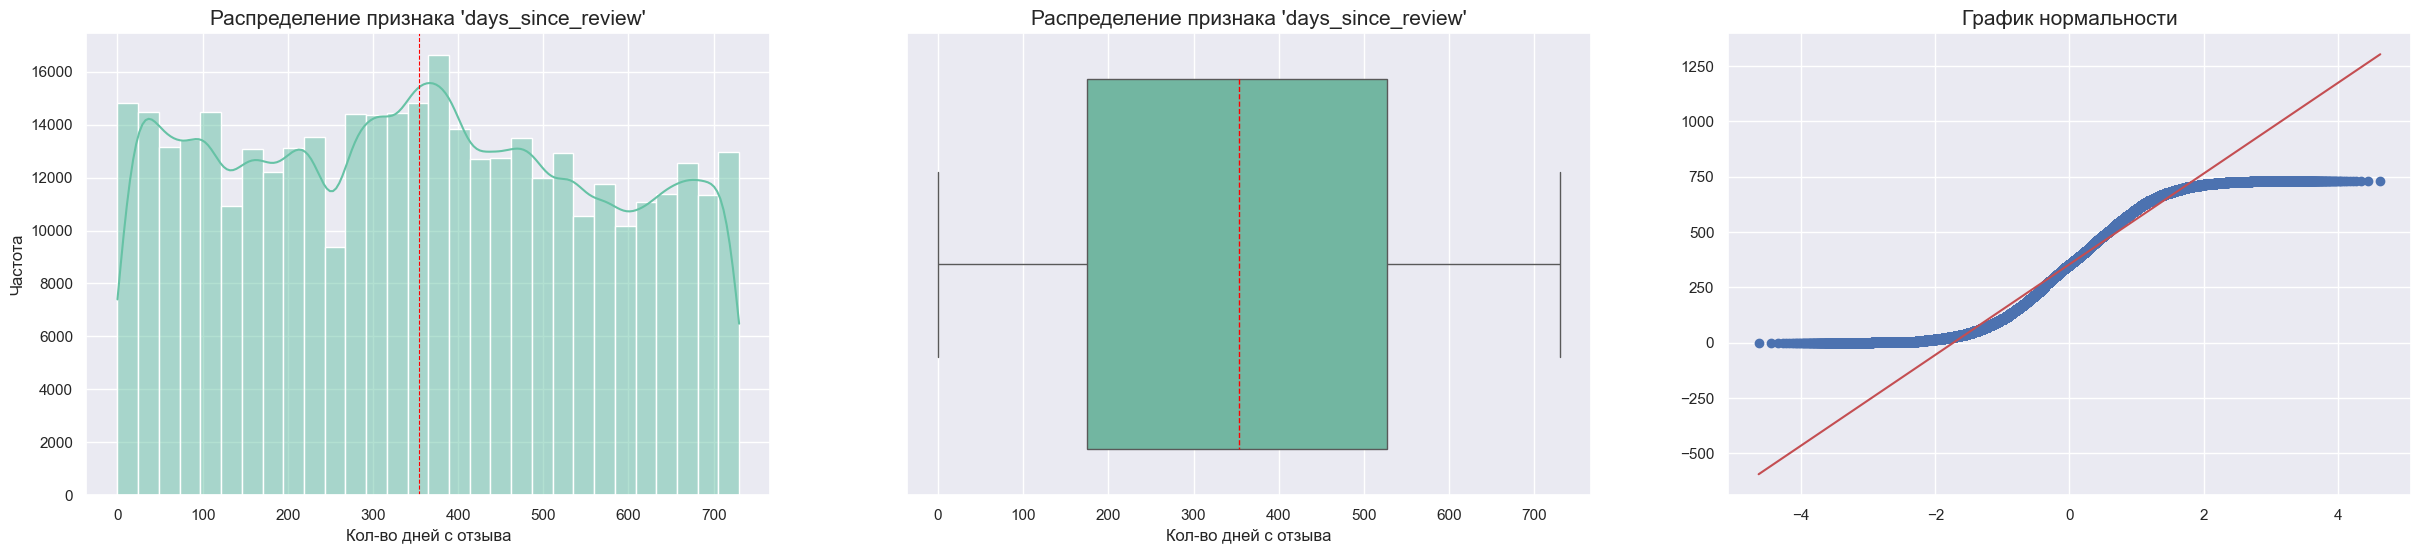

In [145]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['days_since_review'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Распределение признака 'days_since_review'", fontsize=15)
axes[0].set(xlabel='Кол-во дней с отзыва', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['days_since_review'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['days_since_review'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Кол-во дней с отзыва')
axes[1].set_title("Распределение признака 'days_since_review'", fontsize=15)

stats.probplot(data[data['sample']==1]['days_since_review'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

Согласно полученным данным визуального анализа вышеуказанного признака он явно не имеет нормального распределения, но формально проверим данные наблюдения посредством теста:

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [146]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `days_since_review`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['days_since_review'])
decision_normality(result[1])

Для признака `days_since_review`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


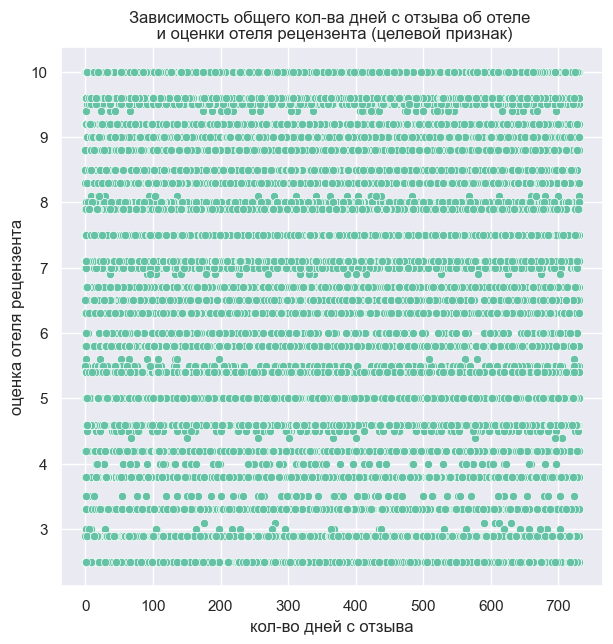

In [147]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='days_since_review', y='reviewer_score')
plot.set(xlabel='кол-во дней с отзыва', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость общего кол-ва дней с отзыва об отеле \n и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `days_since_review`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено отсутствие взаимосвязи между данными признаками. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* с большой долей вероятности будет исключен из модели.

In [148]:
# Добавляем признак в список числовых.
num_cols.append('days_since_review')

## Признаки `lat` и `lng`
***(координты отеля)***

Ранее, на этапе очистки данных мы уже работали с данной парой признаков, заполнив в них пропуски. Сами по себе данные признаки маловероятно будут значимыми, однако предлагается из них сделать новый числовой признак, отображающий расстояние от центра города до самого отеля.

Для получения необходимых дополнительных данных о координатах центра города воспользуемся внешними источниками, а именно ресурсом [https://dateandtime.info/](https://dateandtime.info/), а непосредственно для поиска расстояния от центра города будем использовать метод [***geodesic***](https://geopy.readthedocs.io/en/stable/index.html?highlight=geodesic#geopy.distance.geodesic) модуля `geopy.disnance`.

In [149]:
# Создаем датафрейм координат центра каждого города.
centers = pd.DataFrame(
        [[0, 0, 0, 1, 0, 0, 51.508530, -0.125740],
        [0, 0, 0, 0, 1, 0, 48.853410, 2.348800],
        [0, 0, 1, 0, 0, 0, 41.388790, 2.158990],
        [1, 0, 0, 0, 0, 0, 45.464270, 9.189510],
        [0, 0, 0, 0, 0, 1, 48.208490, 16.372080],
        [0, 1, 0, 0, 0, 0, 52.374030, 4.889690]],
    columns= ['hotel_city_Milan', 'hotel_city_Amsterdam', 'hotel_city_Barcelona',\
              'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Vienna', 'center_lat', 'center_lng']
)

# Копируем исходный датасет.
data_copy = data.copy()
# Инициируем список столбцов под соединение датафреймов.
merge_cols = ['hotel_city_Milan', 'hotel_city_Amsterdam', 'hotel_city_Barcelona','hotel_city_London', 'hotel_city_Paris', 'hotel_city_Vienna']
# Соединяем датафреймы.
data_copy = data_copy.merge(centers, how='left', on=merge_cols, sort=False)
# Применяем функцию для создания признака расстояния от отеля до центра города.
data_copy['dist_to_center'] = data_copy.apply(lambda row: geodesic((row['center_lat'], row['center_lng']),(row['lat'], row['lng'])).km, axis=1)

Далее нам необходимо удалить вспомогательные и старые признаки, на основе которых получен признак `dist_to_center`, применить полученные изменения к основному датасету.

In [150]:
# Удаляем ненужные признаки.
data_copy.drop(['lat', 'lng', 'center_lat', 'center_lng'], axis=1, inplace=True)
# Применяем изменения к искомому датасету.
data = data_copy

А теперь рассмотрим поподробнее новый признак `dist_to_center`

In [151]:
# Отображаем основные описательные характеристики признака.
display(pd.DataFrame(data['dist_to_center'].describe()))
print('')
print(colored(f'Тип данных признака:', 'green'), data['dist_to_center'].dtype, sep='\n')
print(colored(f'\nКоличество уникальных значений:', 'green'), data['dist_to_center'].nunique(), sep='\n')

,dist_to_center
count,515738.000000
mean,3.156804
std,2.569865
min,0.030637
25%,1.316225
50%,2.547625
75%,4.116751
max,17.302738



Тип данных признака:
float64

Количество уникальных значений:
1489


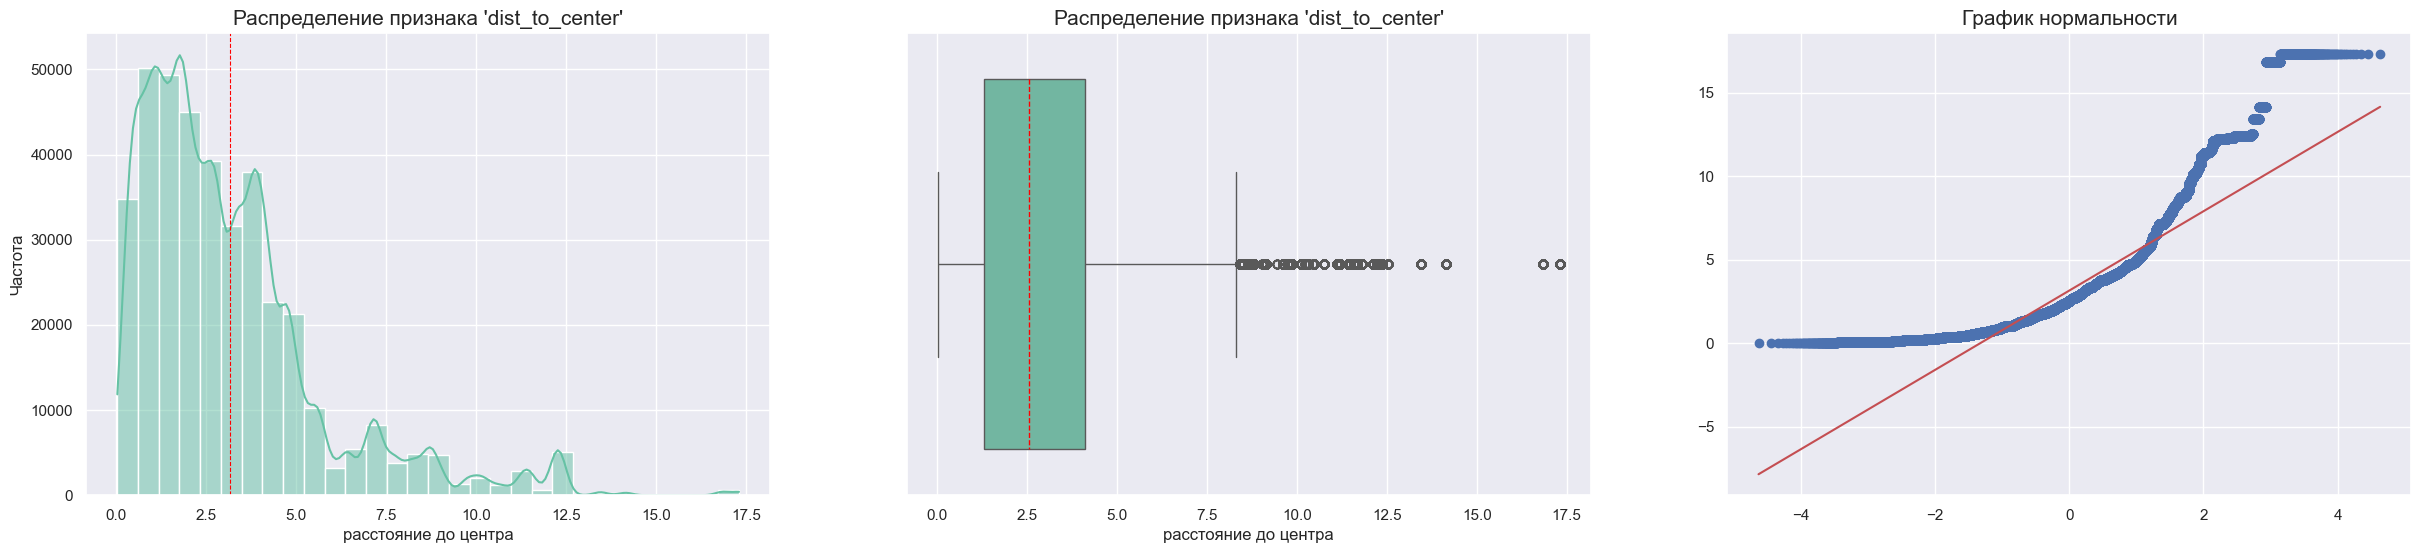

In [152]:
# Осуществляем визуализацию распределения числового признака.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

sns.histplot(data=data[data['sample']==1]['dist_to_center'], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Распределение признака 'dist_to_center'", fontsize=15)
axes[0].set(xlabel='расстояние до центра', ylabel='Частота')
axes[0].axvline(data[data['sample']==1]['dist_to_center'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data[data['sample']==1]['dist_to_center'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='расстояние до центра')
axes[1].set_title("Распределение признака 'dist_to_center'", fontsize=15)

stats.probplot(data[data['sample']==1]['dist_to_center'], plot=axes[2])
axes[2].set(xlabel='', ylabel='')
axes[2].set_title('График нормальности', fontsize=15);

Согласно полученным данным визуального анализа вышеуказанного признака он явно не имеет нормального распределения, но формально проверим данные наблюдения посредством теста:

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [153]:
# Проводим тест Шапиро-Уилка
print(colored('Для признака `dist_to_center`:', 'green'))
result = stats.shapiro(data[data['sample']==1]['dist_to_center'])
decision_normality(result[1])

Для признака `dist_to_center`:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


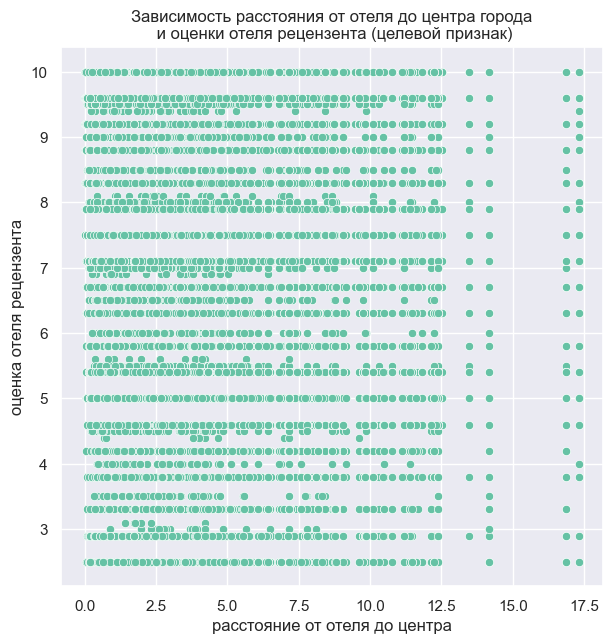

In [154]:
# Визуализация зависимости с целевым признаком посредством диаграммы рассеянивания.
fig = plt.figure(figsize=(7,7))

plot = sns.scatterplot(data=data[data['sample']==1], x='dist_to_center', y='reviewer_score')
plot.set(xlabel='расстояние от отеля до центра', ylabel='оценка отеля рецензента')
plot.set_title('Зависимость расстояния от отеля до центра города\n и оценки отеля рецензента (целевой признак)');

**Вывод по признаку `dist_to_center`:**

Данный признак можно расценивать как непрерывный (числовой), который имеет ненормальное распределение. По результатам визуального анализа корреляции с целевым признаком предварительно выявлено отсутствие взаимосвязи между данными признаками. Данный признак добавляем список признаков `num_cols`, который на дальнейшем этапе *Feature Sellection* будет проверен подробнее.

In [155]:
# Добавляем признак в соответствующий список.
num_cols.append('dist_to_center')

# 3. Последние приготовления признаков, проведение их отбора (*Feature Sellection*)
---

In [156]:
# Копируем искомый датасет для безболезненного дальнейшего варьирования признаками.
data_copy = data.copy()

In [157]:
# отображаем количество имеющихся признаков.
print(colored('Количество непрерывных признаков:', 'green'), len(num_cols))
print(colored('Количество категориальных признаков:', 'green'), len(cat_cols))
print(colored('Общее количество признаков:', 'green'), len(num_cols)+len(cat_cols), '(без учета целевого и выборочного признаков)')

Количество непрерывных признаков: 9
Количество категориальных признаков: 21
Общее количество признаков: 30 (без учета целевого и выборочного признаков)


На финальных этапах подготовки данных предлагается нормализовать непрерывные признаки посредством метода *RobustScaler*, что обусловлено наличием выбросов в ряде признаков.

In [158]:
# Нормализация непрерывных признаков через RobustScaler:
r_scaler = preprocessing.RobustScaler()
data_copy_r = r_scaler.fit_transform(data_copy[num_cols])
data_copy_r = pd.DataFrame(data_copy_r, columns=[num_cols])
# Переносим нормализованные значения в рабочий датасет.
data_copy[num_cols] = data_copy_r[num_cols]

## 3.1 Анализ мультиколлинеарности признаков

***Примечание:***  далее для построения тепловых карт корреляции мы мудем применять метод Кендалла, т.к. он применим к ранговой корреляции для категориальных признаков, а также предпочтителен к применению с непрерывными признаками, которые распределены ненормально и имеют выбросы. 

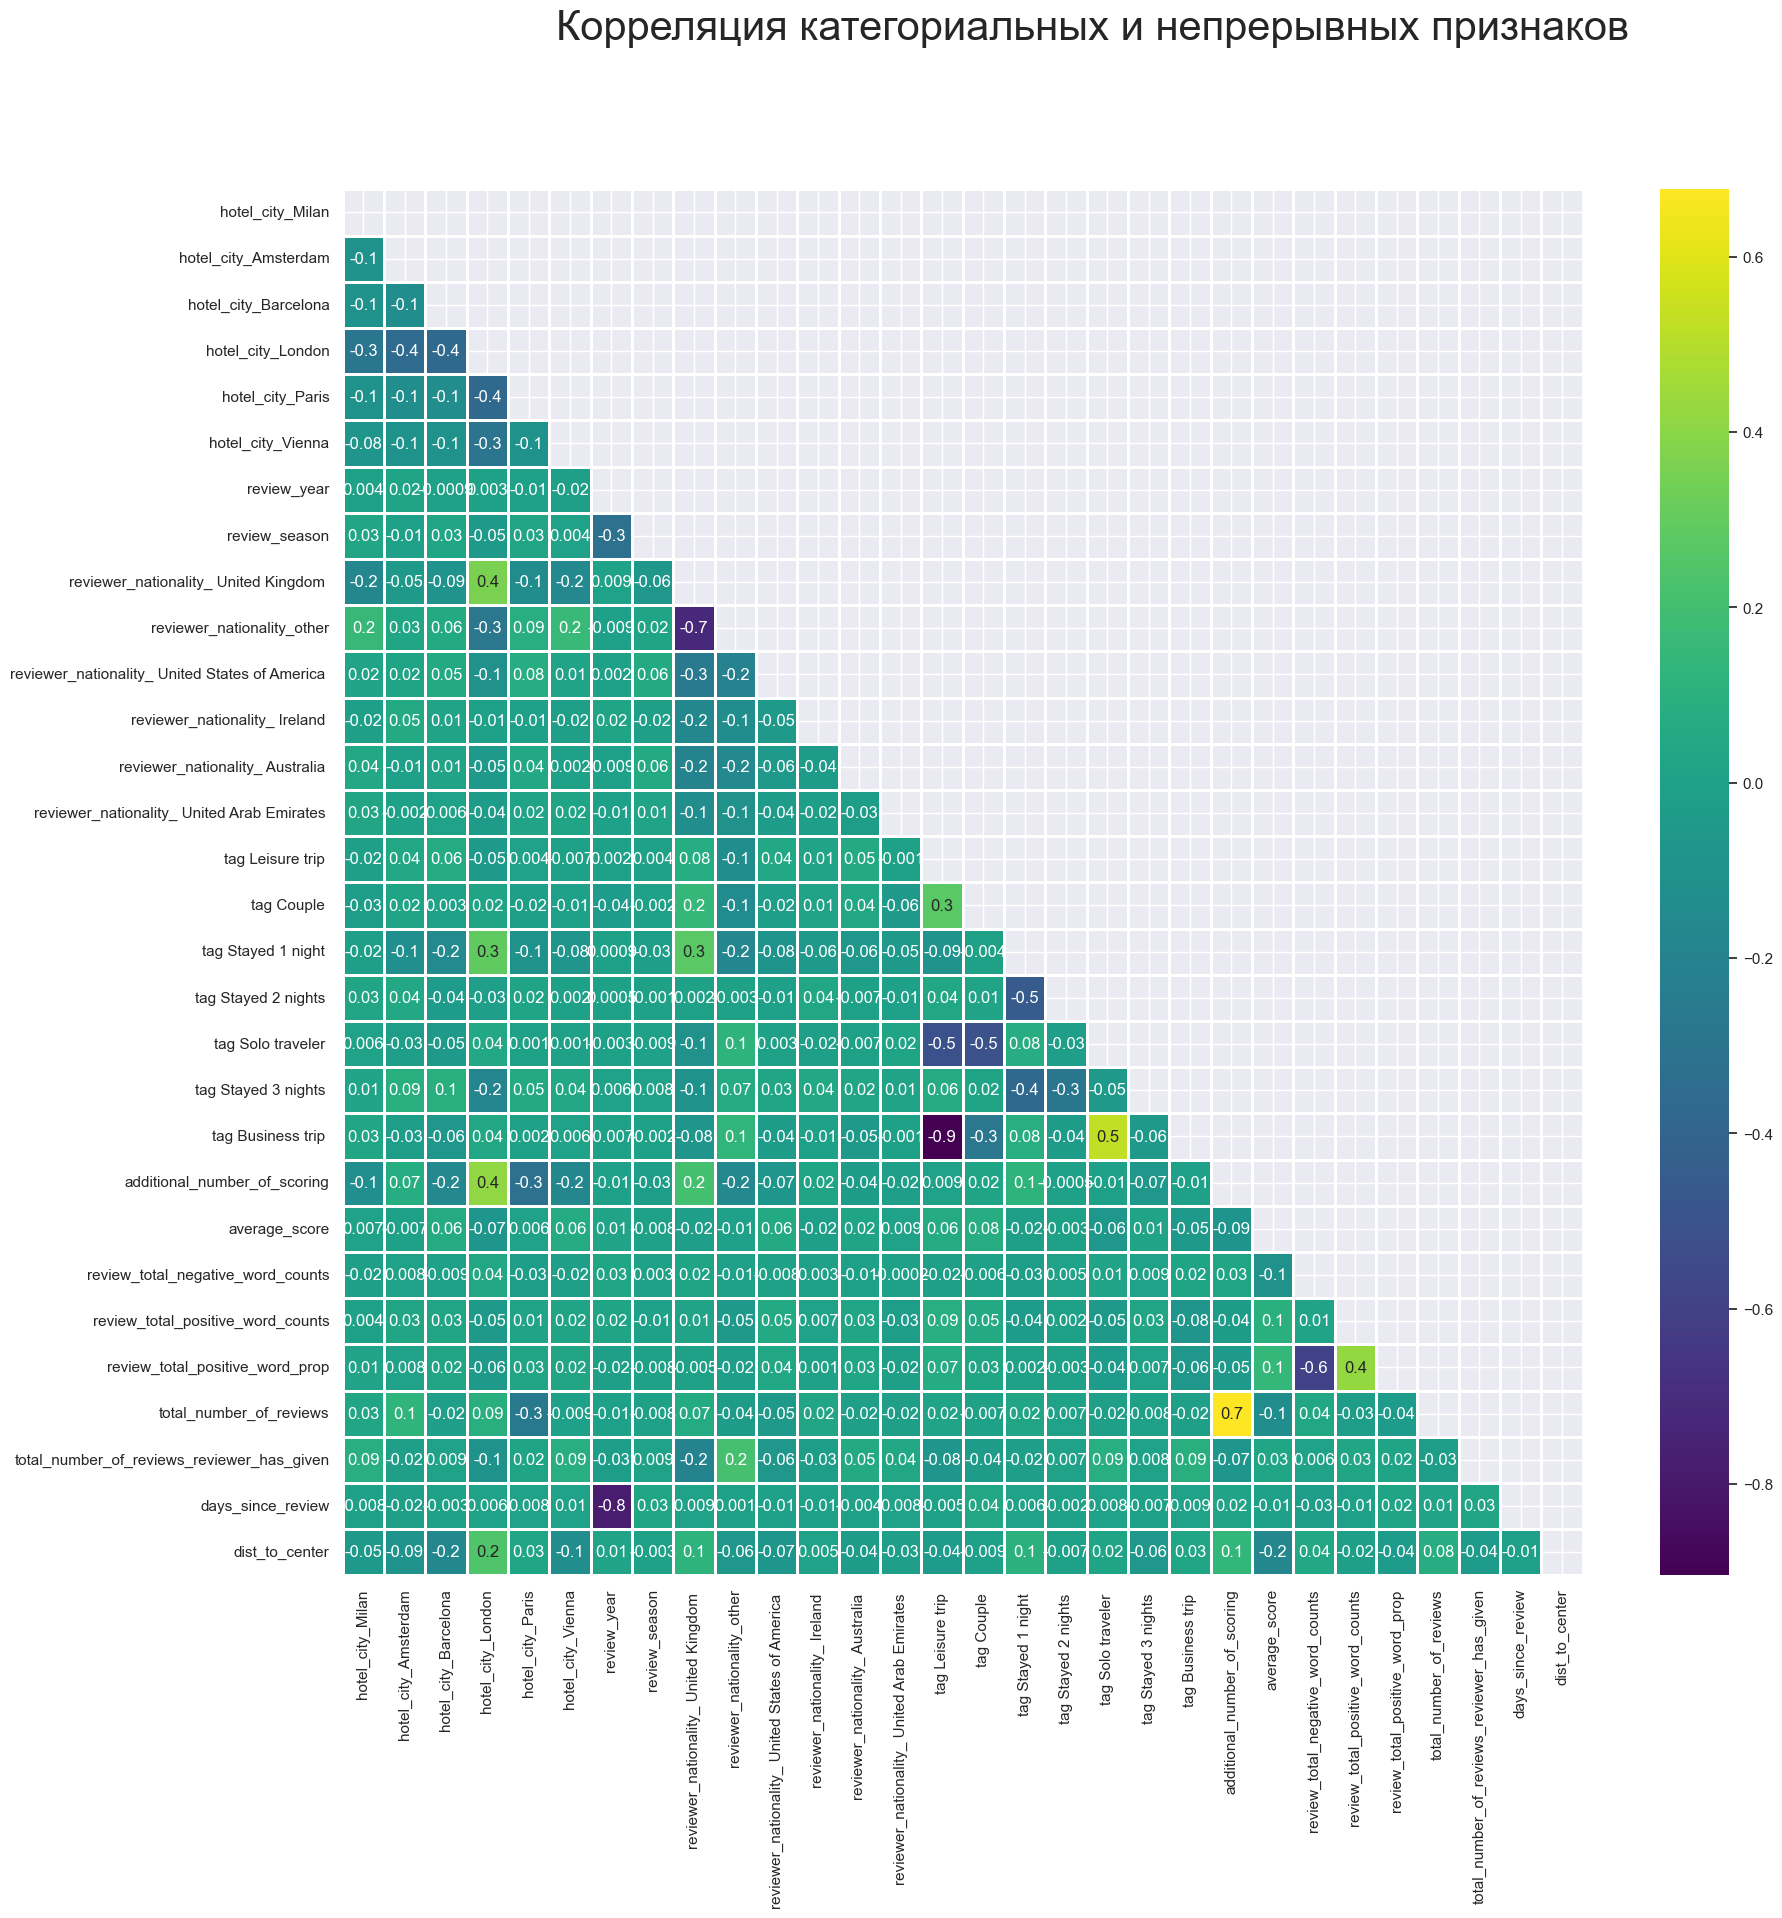

In [159]:
# Визуализируем категориальные и непрерывные признаки.
matrix = np.triu(data_copy[cat_cols+num_cols].corr(method='kendall'))
fig = plt.figure(figsize=(20,18))
fig.suptitle('Корреляция категориальных и непрерывных признаков', fontsize=30)
sns.heatmap(data_copy[cat_cols+num_cols].corr(method='kendall'), annot=True, mask=matrix, fmt='.1g', linewidths=1, cmap= 'viridis');

**Выводы по результатам визуального анализа корреляции признаков:**

- Среди непрерывных признаков сильные связи, подпадающие под мультиколлинеарность не наблюдаются. Оставляем признаки без изменений;

- Среди категориальных признаков мультиколлинеарными являются признаки `tag Leisure trip` и `tag Business trip`, следовательно от одного из них мы избавляемся.

In [160]:
# Удаляем мультиколлинеарный признак.
data_copy.drop('tag Business trip ', axis=1, inplace=True)
cat_cols.remove('tag Business trip ')

print(colored('Количество признаков после проверки:', 'green'), len(data_copy.columns), sep='\n')

Количество признаков после проверки:
31


## 3.2 Проводим оценку значимости признаков

Для оценки значимости непрерывных переменных будем использовать функцию [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) из библиотеки *sklearn*. В основе метода оценки значимости переменных лежит анализ (*ANOVA*).

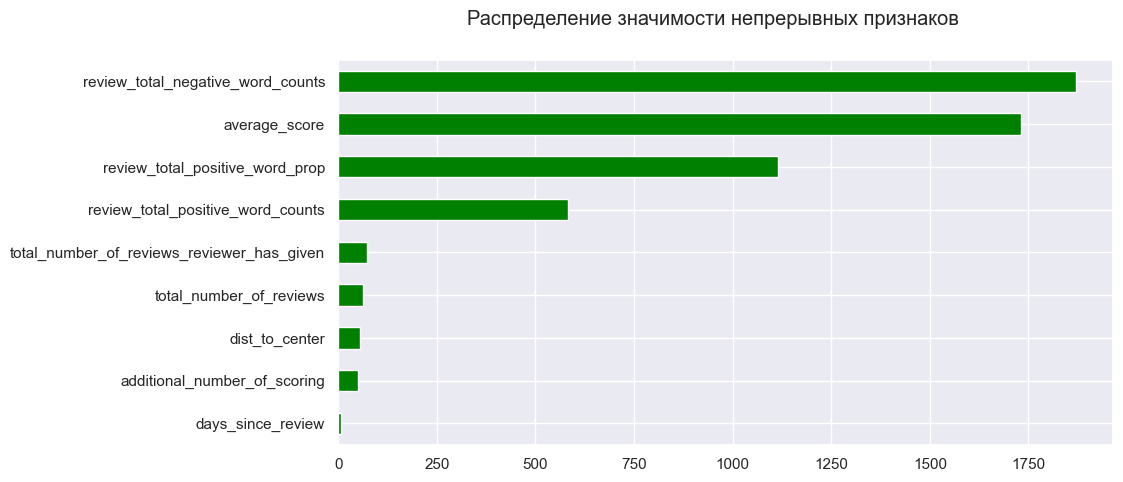

In [161]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей).
y = data_copy[data_copy['sample'] == 1].drop('sample', axis=1)['reviewer_score']
X = data_copy[data_copy['sample'] == 1].drop(['sample', 'reviewer_score'], axis=1)

# Визуализируем результат анализа значимости:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Распределение значимости непрерывных признаков')
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='green');

По итогу вышеуказанных данных целесообразно удалить непрерывный признак `days_since_review`  как не оказывающий никакого влияния на целевой признак. Вместе с тем, установлено, что самое сильное влияние на целевой признак оказывают количество негативных, положительных слов в отзыве, их взаимная пропорция, а также показатель средней оценки.

In [162]:
# Удаляем "слабые" признаки.
data_copy.drop('days_since_review', axis=1, inplace=True)

print(colored('Количество признаков после проверки:', 'green'), len(data_copy.columns), sep='\n')

Количество признаков после проверки:
30


Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке [sklearn.feature_selection.chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2). Метод возвращает массив значений хи-квадрат и *p-value* для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

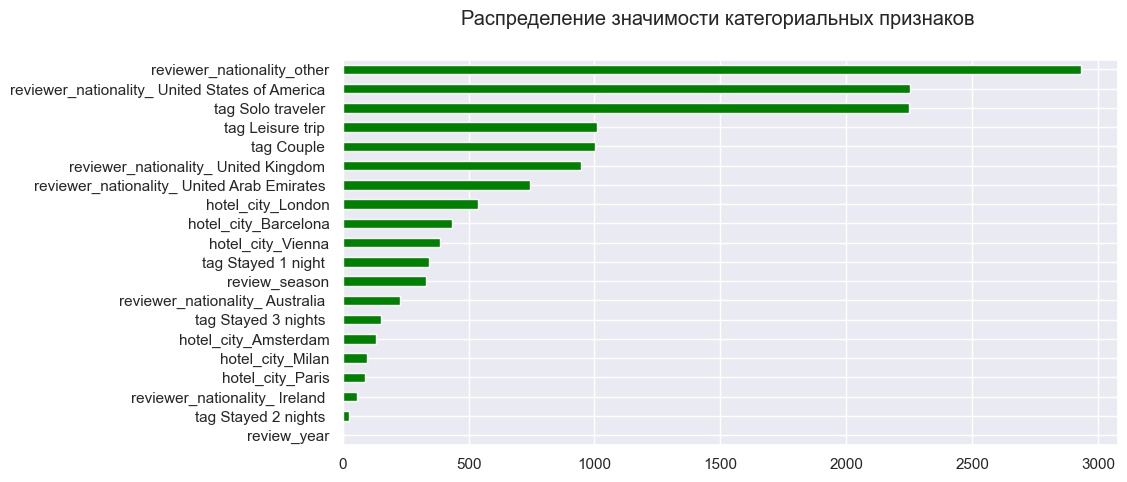

In [163]:
# Приводим к числовому формату.
y=y.astype('int')

# Визуализируем результат анализа значимости:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Распределение значимости категориальных признаков')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='green');

По итогу вышеуказанных данных целесообразно удалить категориальный признак `review_year` как не оказывающий никакого влияния на целевой признак. Вместе с тем, отмечается, что самое сильное влияние на целевой признак оказывают гражданство США рецензента и иные гражданства (не топ 5 по датасету), путешествие в одиночку рецензентом.

In [164]:
# Удаляем "слабые" признаки.
data_copy.drop('review_year', axis=1, inplace=True)

print(colored('Количество признаков после проверки:', 'green'), len(data_copy.columns), sep='\n')

Количество признаков после проверки:
29


# 4. Обучение модели и получение предсказания (*Model Building*):
---

## 4.1 Подготовка исходных данных

In [165]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
train_data = data_copy[data_copy['sample'] == 1].drop('sample', axis=1)
test_data = data_copy[data_copy['sample'] == 0].drop('sample', axis=1)

# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей).
y = train_data['reviewer_score']
X = train_data.drop('reviewer_score', axis=1)

In [166]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [167]:
# Проверяем размерность.
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 28), (386803, 28), (386803, 27), (309442, 27), (77361, 27))

## 4.2 Непосредственное создание модели

In [168]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [169]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: total: 5min 45s
Wall time: 1min 39s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [170]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print(colored('MAPE:', 'green'), round(mean_absolute_percentage_error(y_test, y_pred), 2), '%', sep=' ')

MAPE: 13.61 %


### Вклад важнейших признаков в построение модели.

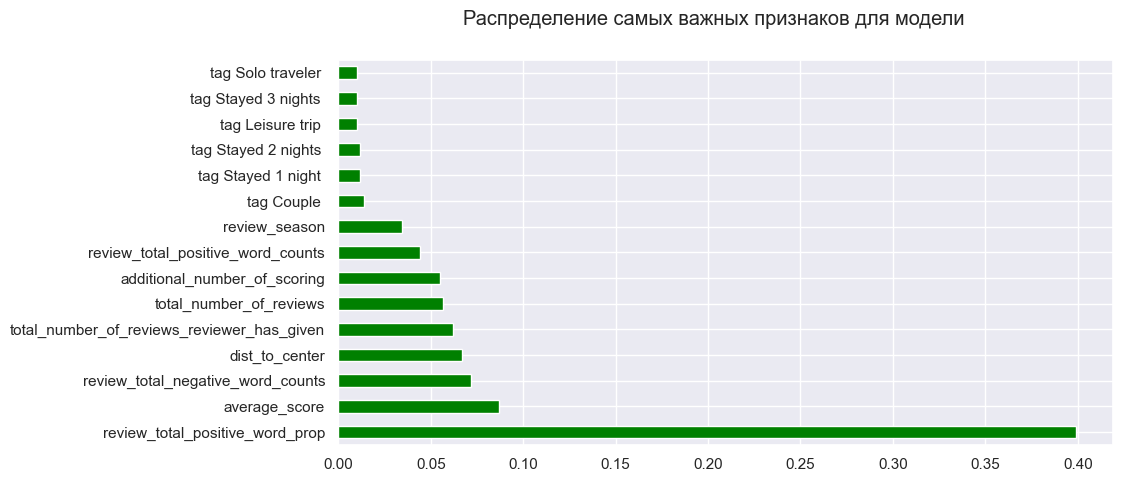

In [171]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
fig = plt.figure(figsize=(10,5))
fig.suptitle('Распределение самых важных признаков для модели')
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

Как мы видим из представленного выше графика, созданный нами на стадии *Feature Engineering'*а признак пропорции положительных слов и отрицательных в отзывах сыграл в нашей модели ключевую роль.

### Получаем предсказание целевой переменной

In [172]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

# Сохраняем результат:
sample_submission.to_csv('data/submission_result.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


,reviewer_score,id
0,8.507,488440
1,6.627,274649
2,8.056,374688
3,9.460,404352
4,9.402,451596
5,8.404,302161
6,8.029,317079
7,7.678,13963
8,9.020,159785
9,8.085,195089


# 5. Выводы по работе
---

Следует отметить, что при подборе различных вариантов моделей ни нормализация, ни стандартизация непрерывных признаков ровным счетом не изменила результат метрики *MAPE*. В то же время хочется отметить как положительную сторону данной работы (хоть и не с выском показателем итоговой метрики *MAPE*) проектирование признака пропорции положительных слов в отзые и отрицательных слов `review_total_positive_word_prop`, который в построенной модели оказал решающую роль в предсказании.